In [1]:
import os
import sys
sys.path.append(r"C:\Users\Alireza\Documents\Git\Cosine-Project")
from core.utils.image_analysis import *
from core.utils.basic_functions import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import re
from torchvision.transforms import ToPILImage, PILToTensor, ToTensor
from torchvision import transforms
from PIL import Image
from scipy import stats, ndimage
from torchvision.utils import make_grid
from datetime import datetime, timedelta


In [2]:
# set some paths
data_root = r"C:\Users\Alireza\OneDrive - Harvard University\Documents\cosine_preprocess_data"


animal_name = "Caos"
server_init = r"N:\PonceLab"
save_root = os.path.join(r"C:\Users\Alireza\OneDrive - Harvard University\Documents\coisne_results", f"reconstraction_results_{animal_name}")
os.makedirs(save_root, exist_ok=True)

# Define the paths to the data
recon_exp_path = os.path.join(data_root, 'recon', f"recon_data_{animal_name}")
proto_exp_path = os.path.join(data_root, "evolution", f"unit_proto_{animal_name}")
scram_exp_path = os.path.join(data_root, "scram", f"unit_scram_{animal_name}")

# List .mat files in each directory
recon_exp_files = list_mat_files(recon_exp_path)
proto_exp_files = list_mat_files(proto_exp_path)
scram_exp_files = list_mat_files(scram_exp_path)

time_window = 30
bim_mas_threshold = 1.25

In [3]:
# let load the proto and corosponding mask if it posible plus the size 
# let save the proto and mask and other info in a pd
proto_and_mask_info = pd.DataFrame(columns=['exp_name', 'exp_id', 'proto_img_top_mean', 'proto_img_scram',
                                            'proto_mask_exp', 'proto_mask_lin', 'proto_mask_lin_smoothed',
                                            'proto_size', 'proto_pos', 'chan_id', 'unit_id',
                                            'protoRespMean', 'init_img', 'exp_date'])
c = 0
iamge_size = 256
non_significant_exp = []
for proto_exp_i in range(len(proto_exp_files)):
    # use the extract_info function to extract the information from the filename
    #proto_file = [f for f in proto_exp_files if f.count(f"expId{proto_exp_id+1:03d}")][0]
    proto_file = proto_exp_files[proto_exp_i]
    proto_exp_data = mat73.loadmat(os.path.join(proto_exp_path, proto_file))
    proto_exp_info = extract_info_proto_exp(proto_file)
    exp_name_common = '-'.join(proto_exp_info['exp_name'].split('-')[0:2])
    chan_id = proto_exp_info['chan']
    unit_id = proto_exp_info['unit']
    proto_exp_id = proto_exp_info['expId']

    # the scram exp data file name is formated like this [exp_name]_exp_idXXX_chanXX_unitX.mat for example like Caos-30112023-008_expId022_chan71_unit2
    # let's load the coresponded scram exp data which should be [exp_name_common]-*_chan[chan_id]_unit[unit_id].mat
    scram_exp_file = [f for f in scram_exp_files if (f.count(f"chan{chan_id:02d}") and f.count(f"unit{unit_id}") and f.count(exp_name_common))]
    # continue if the file is not found
    if len(scram_exp_file) == 0:
        continue
    if (proto_exp_data['p_evol'] > .01):
        non_significant_exp.append(proto_exp_id)
        continue
    scram_exp_file = scram_exp_file[0]
    scram_exp_info = mat73.loadmat(os.path.join(scram_exp_path, scram_exp_file))
    proto_size = scram_exp_info['img_size']
    proto_pos = scram_exp_info['img_pos']
    protoRespMean = scram_exp_info['protoRespMean']
    exp_date = scram_exp_file.split('_')[0].split('-')[1]
    exp_datetime_obj = parse_date(exp_date, animal_name=animal_name)

    proto_img_top_mean = proto_exp_data['top_mean_img_selected'] # TODO: if you add somthing here you should resize it
    proto_img_scram = scram_exp_info['final_gen_img']
    init_img = proto_exp_data['init_img']
    proto_mask_exp = scram_exp_info['overlapped_mask_exp']
    proto_mask_lin = scram_exp_info['overlapped_mask_lin']
    proto_mask_lin_smoothed = ndimage.gaussian_filter(proto_mask_lin, 25)
    # if mask is not the size of image_size then resize it
    if proto_mask_exp.shape[0] != iamge_size:
        proto_mask_exp = cv2.resize(proto_mask_exp, (iamge_size, iamge_size))
    if proto_mask_lin.shape[0] != iamge_size:
        proto_mask_lin = cv2.resize(proto_mask_lin, (iamge_size, iamge_size))
    if proto_mask_lin_smoothed.shape[0] != iamge_size:
        proto_mask_lin_smoothed = cv2.resize(proto_mask_lin_smoothed, (iamge_size, iamge_size))
    # if the proto_img is not the size of image_size then resize it
    if proto_img_top_mean.shape[0] != iamge_size:
        proto_img = cv2.resize(proto_img, (iamge_size, iamge_size))
    if proto_img_scram.shape[0] != iamge_size:
        proto_img_scram = cv2.resize(proto_img_scram, (iamge_size, iamge_size))
    # iloc with c
    proto_and_mask_info.loc[c] = [exp_name_common, proto_exp_id, proto_img_top_mean, proto_img_scram,
                                   proto_mask_exp, proto_mask_lin, proto_mask_lin_smoothed,
                                   proto_size, proto_pos, chan_id, unit_id, protoRespMean, init_img, exp_datetime_obj]
    c += 1
proto_and_mask_info['proto_img_mean_torch'] = proto_and_mask_info['proto_img_top_mean'].apply(uint8_image_to_pytorch)
proto_and_mask_info['proto_img_scram_torch'] = proto_and_mask_info['proto_img_scram'].apply(uint8_image_to_pytorch)
proto_and_mask_info['init_img_torch'] = proto_and_mask_info['init_img'].apply(uint8_image_to_pytorch)
print(f"Number of expected proto images: {len(scram_exp_files)- len(non_significant_exp)}")
print(f"Number of proto images loaded: {len(proto_and_mask_info)}")

Number of expected proto images: 106
Number of proto images loaded: 107


In [4]:
# let get the summary of the score results which is contin the score for each thread, initial gen, best gen, noise ceiling and p_val and some info for the recon data
# such as file_name, exp_name, masking condition, score_mode, sampling_mode, ...

avg_strip = 2
file_name_patern = r'^(.*?)_expId(\d{3}).mat$'

score_data_pd = pd.DataFrame(columns= ['exp_name', 'exp_i', 'exp_id', 'file_name', 'thread_id', 'score_mode', 'array_inc', 'sampling_mode', 'img_poss', 'img_size', 'score_from_bhv', 
                                       'score_means_smooth', 'score_means', 'score_stds', 'score_sems', 'score_gens', 'best_gen', 'inital_gen_score', 'best_gen_score', 'score_means_MSE', 'score_stds_MSE', 
                                       'score_sems_MSE', 'score_gens_MSE', 'score_means_smooth_MSE', 'best_gen_MSE', 'inital_gen_score_MSE', 'best_gen_score_MSE', 
                                       'p_val', 'p_val_MSE', 'noise_ceiling_all_trails', 'noise_ceiling_half_draw', 'noise_ceiling_one_out', 'noise_ceiling_all_trails_MSE', 'noise_ceiling_half_draw_MSE', 'noise_ceiling_one_out_MSE',
                                       'target_resp_from_select', 'best_gen_resp_mean', 'best_gen_resp_sem', 'ini_resp_mean', 'ini_resp_sem', 
                                       'target_resp_mask', 'best_gen_resp_mask', 'ini_resp_mask', 'p_val_init_target', 'p_val_best_target', 'p_val_init_target_greater', 'p_val_init_best_greater',    
                                        'chan_ids', 'unit_ids',
                                        'hand_chose_mask_flag', 'use_responsive_mask', 'use_selective_mask', 'exp_date'])
                             
for exp_i in range(len(recon_exp_files)):
    file_name = recon_exp_files[exp_i] 
    matches = re.match(file_name_patern, file_name)
    exp_name, expriment_id = matches.groups()
    expriment_id = int(expriment_id)
    exp_date = exp_name.split('-')[1]
    exp_datetime_obj = parse_date(exp_date, animal_name=animal_name)

    recon_data = load_mat_data(os.path.join(recon_exp_path, recon_exp_files[exp_i]))
    nun_of_thread = int(recon_data['num_of_thread'])

    for iThread in range(nun_of_thread):
        is_gen, block_ids, thread_ids, gen_ids, counters, is_nat, nat_gen = process_gen_image_strings(recon_data['all_img_name_recon'])
        thread_mask = (thread_ids == iThread)
        sub_resp = recon_data['evoke_resp_recon'] - recon_data['bk_resp_reocn']
        #evoked_resp = recon_data['evoke_resp_recon']
        
        target_resp_from_select = recon_data['target_resps_cell'][iThread]
        total_mean = recon_data['pop_mean_call'][iThread]
        total_std = recon_data['pop_std_cell'][iThread]
        target_resp_from_select = (target_resp_from_select- total_mean) / total_std
        sub_resp_norm = (sub_resp - total_mean[:, None]) / total_std[:, None]

        resp_mean, resp_std, resp_sem, resp_uique_gen = analyze_by_gen(sub_resp_norm[:, thread_mask], gen_ids[thread_mask])

        resp_mean = resp_mean[recon_data['masks_cell'][iThread]]
        resp_std = resp_std[recon_data['masks_cell'][iThread]]
        resp_sem = resp_sem[recon_data['masks_cell'][iThread]]
        target_resp_from_select = target_resp_from_select[recon_data['masks_cell'][iThread]]
        

        this_thread_imgs = recon_data['all_img_name_recon'][thread_mask]
        score_vec = get_score_from_resp(sub_resp, recon_data['target_resps_cell'][iThread], recon_data['masks_cell'][iThread], recon_data['score_mods'][iThread], recon_data['pop_mean_call'][iThread], recon_data['pop_std_cell'][iThread])
        score_means, score_stds, score_sems, score_gens = analyze_by_gen(score_vec[thread_mask], gen_ids[thread_mask])
        score_from_bhv =np.array([np.nanmean(x) for x in recon_data['score_cell_bhv2']])
        # let replace score of each gen (except the first one) with the mean of the previous gens
        score_means_smooth = score_means.copy()
        for i in range(1, len(score_means)):
            score_means_smooth[i] = np.nanmean(score_means[i-avg_strip+1:i+1])
        best_gen = int(score_gens[np.argmax(score_means_smooth)])
        inital_gen_score = score_vec[thread_mask & (gen_ids == 0)]
        best_gen_score = score_vec[thread_mask & (gen_ids == best_gen)] # score_vec[thread_mask & ((gen_ids == best_gen) | (gen_ids == best_gen-1))] #TODO ASK THIS

        best_gen_resp_mean = resp_mean[:, resp_uique_gen == best_gen]
        best_gen_resp_sem = resp_sem[:, resp_uique_gen == best_gen]

        ini_resp_mean = resp_mean[:, resp_uique_gen == 0]
        ini_resp_sem = resp_sem[:, resp_uique_gen == 0]


        # let's find the noise ceiling
        evoke_resp_select = recon_data['evoke_resp_select']
        bk_resp_select = recon_data['bk_resp_select']
        sub_resp_select = evoke_resp_select - bk_resp_select
        target_img_name = recon_data['target_name'][iThread]
        target_img_idx = [(target_img_name == img_name) for img_name in recon_data['all_img_name_select']]
        target_resp_from_mat = sub_resp_select[:, target_img_idx]
        unit_ids_select = recon_data['unit_ids_select']
        unit_ids_recon = recon_data['unit_ids_recon']
        select_mask = get_selectivity_exp_coresponded_mask(recon_data, iThread)
        all_trails_noise, half_draw_noise, one_out_noise = get_target_noise_celling(
                target_resp_from_mat, select_mask, recon_data['score_mods'][iThread], recon_data['pop_mean_call'][iThread], recon_data['pop_std_cell'][iThread], diff_mask= True, second_mask = recon_data['masks_cell'][iThread]) 
        # let's tun the rank sum test (wilcoxon) one sided to see if the best gen is better than the initial gen
        _, p_val = stats.ranksums(inital_gen_score, best_gen_score, alternative='less') 

        # let here have get score with MSE no matter what the score mode is
        # let's get the MSE score
        score_vec_MSE = get_score_from_resp(sub_resp, recon_data['target_resps_cell'][iThread], recon_data['masks_cell'][iThread], 'MSE', recon_data['pop_mean_call'][iThread], recon_data['pop_std_cell'][iThread])
        score_means_MSE, score_stds_MSE, score_sems_MSE, score_gens_MSE = analyze_by_gen(score_vec_MSE[thread_mask], gen_ids[thread_mask])
        score_means_smooth_MSE = score_means_MSE.copy()
        for i in range(1, len(score_means_MSE)):
            score_means_smooth_MSE[i] = np.nanmean(score_means_MSE[i-avg_strip+1:i+1])
        best_gen_MSE = int(score_gens_MSE[np.argmax(score_means_smooth_MSE)])
        inital_gen_score_MSE = score_vec_MSE[thread_mask & (gen_ids == 0)]
        best_gen_score_MSE = score_vec_MSE[thread_mask & ((gen_ids == best_gen_MSE))] # score_vec_MSE[thread_mask & ((gen_ids == best_gen_MSE) | (gen_ids == best_gen_MSE-1))] #TODO ASK THIS
        # let's tun the rank sum test (wilcoxon) one sided to see if the best gen is better than the initial gen
        _, p_val_MSE = stats.ranksums(inital_gen_score_MSE, best_gen_score_MSE, alternative='less')

        all_trails_noise_MSE, half_draw_noise_MSE, one_out_noise_MSE = get_target_noise_celling(
                target_resp_from_mat, select_mask, 'MSE', recon_data['pop_mean_call'][iThread], recon_data['pop_std_cell'][iThread], diff_mask= True, second_mask = recon_data['masks_cell'][iThread])
        
        # let which neurons have different responses to target to initial gen and best gen
        target_resp_mask = target_resp_from_mat[select_mask, :]
        best_gen_resp_mask = sub_resp[recon_data['masks_cell'][iThread], :][:, ((gen_ids == best_gen) & (thread_ids == iThread))]
        ini_resp_mask = sub_resp[recon_data['masks_cell'][iThread], :][:, ((gen_ids == 0) & (thread_ids == iThread))]

        p_val_init_target = list()
        p_val_best_target = list()
        p_val_init_target_greater = list()
        p_val_init_best_greater = list()
        for i in range(target_resp_mask.shape[0]):
                _, p_val_i_t = stats.ranksums(ini_resp_mask[i, :], target_resp_mask[i, :])
                _, p_val_i_b = stats.ranksums(best_gen_resp_mask[i, :], target_resp_mask[i, :])
                _, p_val_i_t_g = stats.ranksums(ini_resp_mask[i, :], target_resp_mask[i, :], alternative='less')
                _, p_val_i_b_g = stats.ranksums(ini_resp_mask[i, :], best_gen_resp_mask[i, :], alternative='less')
                p_val_init_target.append(p_val_i_t)
                p_val_best_target.append(p_val_i_b)
                p_val_init_target_greater.append(p_val_i_t_g)
                p_val_init_best_greater.append(p_val_i_b_g)


        chan_ids = recon_data['chan_ids_recon'][recon_data['masks_cell'][iThread]]
        unit_ids = recon_data['unit_ids_recon'][recon_data['masks_cell'][iThread]]

        
    

        data_pd = pd.DataFrame({'exp_name': exp_name, 'exp_i': exp_i,  'exp_id': expriment_id, 'file_name': file_name, 'thread_id': iThread,
                'score_mode': recon_data['score_mods'][iThread], 'array_inc': [recon_data['array_inc'][iThread]],
                'sampling_mode': recon_data['sampling_mods'][iThread], 'img_poss': [recon_data['img_poss'][iThread]], 'img_size': recon_data['img_size'][iThread], 
                'score_from_bhv': [score_from_bhv], 'score_means_smooth': [score_means_smooth], 'score_means': [score_means], 'score_stds': [score_stds], 'score_sems': [score_sems], 'score_gens': [score_gens], 
                'best_gen': [best_gen], 'inital_gen_score': [inital_gen_score], 'best_gen_score': [best_gen_score],
                'score_means_MSE': [score_means_MSE], 'score_stds_MSE': [score_stds_MSE], 'score_sems_MSE': [score_sems_MSE], 'score_gens_MSE': [score_gens_MSE], 'score_means_smooth_MSE': [score_means_smooth_MSE],
                'best_gen_MSE': [best_gen_MSE], 'inital_gen_score_MSE': [inital_gen_score_MSE], 'best_gen_score_MSE': [best_gen_score_MSE], 'p_val': p_val, 'p_val_MSE': p_val_MSE,
                'noise_ceiling_all_trails': [all_trails_noise], 'noise_ceiling_half_draw': [half_draw_noise], 'noise_ceiling_one_out': [one_out_noise],
                'noise_ceiling_all_trails_MSE': [all_trails_noise_MSE], 'noise_ceiling_half_draw_MSE': [half_draw_noise_MSE], 'noise_ceiling_one_out_MSE': [one_out_noise_MSE],
                'target_resp_from_select': [target_resp_from_select], 'best_gen_resp_mean': [best_gen_resp_mean], 'best_gen_resp_sem': [best_gen_resp_sem], 'ini_resp_mean': [ini_resp_mean], 'ini_resp_sem': [ini_resp_sem],
                'target_resp_mask': [target_resp_mask], 'best_gen_resp_mask': [best_gen_resp_mask], 'ini_resp_mask': [ini_resp_mask], 'p_val_init_target': [p_val_init_target], 'p_val_best_target': [p_val_best_target],
                'p_val_init_target_greater': [p_val_init_target_greater], 'p_val_init_best_greater': [p_val_init_best_greater],
                'hand_chose_mask_flag': recon_data['hand_chose_mask_flag'], 'use_responsive_mask': recon_data['use_responsive_mask'], 'use_selective_mask': recon_data['use_selective_mask'], 'exp_date': exp_datetime_obj})
        
        score_data_pd = pd.concat([score_data_pd, data_pd])
score_data_pd.reset_index(inplace=True)
score_data_pd['array_inc_open'] = [x[0] for x in score_data_pd['array_inc']]

        


ERROR:root:ERROR: MATLAB type not supported: string, (uint32)
C:\Users\Alireza\Documents\Git\Cosine-Project\core\utils\basic_functions.py:547: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data[key] = np.array(list_keys)
C:\Users\Alireza\Documents\Git\Cosine-Project\core\utils\basic_functions.py:124: RuntimeWarning: Mean of empty slice
  gen_means[:, i] = np.nanmean(gen_values, axis=1)
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\numpy\lib\nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
ERROR:root:ERROR: MATLAB type not supported: string, (uint32)
C:\Users\Alireza\AppData\Local\Temp\ipykernel_24220\2278462832.py:37: RuntimeWarning: divide by zero encountered in 

In [5]:
# Get the recon images and the scores
rcon_img_pd =  pd.DataFrame(columns=['exp_name', 'exp_i', 'exp_id', 'file_name', 'thread_id', 'score_mode', 'array_inc', 'sampling_mode', 'img_poss', 'img_size',
                                     'best_gen', 'init_gen', 'last_get', 'target_image', 
                                     'target_resp_mask', 'best_gen_resp_mask', 'ini_resp_mask', 'p_val_init_target', 'p_val_best_target', 'p_val_init_target_greater', 'p_val_init_best_greater',
                                     'chan_ids', 'unit_ids',
                                     'target_resp_from_select', 'best_gen_resp_mean', 'best_gen_resp_sem', 'ini_resp_mean', 'ini_resp_sem', 'last_gen_resp_mean', 'last_gen_resp_sem', 'exp_date', 
                                     'best_image_score_dict', 'init_image_score_dict', 'last_imge_score_dict'])
last_get_wind = 4
for exp_i in range(len(recon_exp_files)):
    file_name = recon_exp_files[exp_i] 
    matches = re.match(file_name_patern, file_name)
    exp_name, expriment_id = matches.groups()
    expriment_id = int(expriment_id)
    exp_date = exp_name.split('-')[1]
    exp_datetime_obj = parse_date(exp_date, animal_name=animal_name)

    recon_data = load_mat_data(os.path.join(recon_exp_path, recon_exp_files[exp_i]))
    nun_of_thread = int(recon_data['num_of_thread'])

    for iThread in range(nun_of_thread):
        is_gen, block_ids, thread_ids, gen_ids, counters, is_nat, nat_gen = process_gen_image_strings(recon_data['all_img_name_recon'])
        thread_mask = (thread_ids == iThread)

        sub_resp = recon_data['evoke_resp_recon'] - recon_data['bk_resp_reocn']
        evoked_resp = recon_data['evoke_resp_recon']

        all_img_name = recon_data['all_img_name_recon']
        stimuli_path_recon = recon_data['stimuli_path_recon']
        stimuli_path_select = recon_data['stimuli_path_select']
                
        target_resp_from_select = recon_data['target_resps_cell'][iThread]
        #total_mean = recon_data['pop_mean_call'][iThread]
        #total_std = recon_data['pop_std_cell'][iThread]
        #target_resp_from_select = (target_resp_from_select- total_mean) / total_std
        #sub_resp_norm = (sub_resp - total_mean[:, None]) / total_std[:, None]

        target_resp_from_select = target_resp_from_select[recon_data['masks_cell'][iThread]]
        evoked_resp = evoked_resp[recon_data['masks_cell'][iThread], :]
        resp_mean, resp_std, resp_sem, resp_uique_gen = analyze_by_gen(evoked_resp[:, thread_mask], gen_ids[thread_mask])
        
        
        target_name = recon_data['target_name'][iThread]
        score_vec = get_score_from_resp(sub_resp, recon_data['target_resps_cell'][iThread], recon_data['masks_cell'][iThread],
                                        recon_data['score_mods'][iThread], recon_data['pop_mean_call'][iThread], recon_data['pop_std_cell'][iThread])
        
        best_gen = score_data_pd['best_gen'][(score_data_pd['exp_i'] == exp_i) & (score_data_pd['thread_id'] == iThread)].values[0]
        init_gen = 0

        best_gen_resp_mean = resp_mean[:, resp_uique_gen == best_gen]
        best_gen_resp_sem = resp_sem[:, resp_uique_gen == best_gen]

        ini_resp_mean = resp_mean[:, resp_uique_gen == init_gen]
        ini_resp_sem = resp_sem[:, resp_uique_gen == init_gen]
        

        best_last_three_gens = np.argmax(score_data_pd['score_means'][(score_data_pd['exp_i'] == exp_i) & (score_data_pd['thread_id'] == iThread)].values[0][-last_get_wind:])
        last_get = np.max([len(score_data_pd['score_means'][(score_data_pd['exp_i'] == exp_i) & (score_data_pd['thread_id'] == iThread)].values[0])-last_get_wind+best_last_three_gens, best_gen])

        last_gen_resp_mean = resp_mean[:, resp_uique_gen == last_get]
        last_gen_resp_sem = resp_sem[:, resp_uique_gen == last_get]

        # let see which neurons have different responses to target to initial gen and best gen
        evoke_resp_select = recon_data['evoke_resp_select']
        bk_resp_select = recon_data['bk_resp_select']
        sub_resp_select = evoke_resp_select - bk_resp_select
        target_img_name = recon_data['target_name'][iThread]
        target_img_idx = [(target_img_name == img_name) for img_name in recon_data['all_img_name_select']]


        target_resp_from_mat = sub_resp_select[:, target_img_idx]
        unit_ids_select = recon_data['unit_ids_select']
        unit_ids_recon = recon_data['unit_ids_recon']
        select_mask = get_selectivity_exp_coresponded_mask(recon_data, iThread)
        target_resp_mask = target_resp_from_mat[select_mask, :]
        
        best_gen_resp_mask = sub_resp[recon_data['masks_cell'][iThread], :][:, ((gen_ids == best_gen) & (thread_ids == iThread))]
        ini_resp_mask = sub_resp[recon_data['masks_cell'][iThread], :][:, ((gen_ids == init_gen) & (thread_ids == iThread))]

        p_val_init_target = list()
        p_val_best_target = list()
        p_val_init_target_greater = list()
        p_val_init_best_greater = list()
        for i in range(target_resp_mask.shape[0]):
                _, p_val_i_t = stats.ranksums(ini_resp_mask[i, :], target_resp_mask[i, :])
                _, p_val_i_b = stats.ranksums(best_gen_resp_mask[i, :], target_resp_mask[i, :])
                _, p_val_i_t_g = stats.ranksums(ini_resp_mask[i, :], target_resp_mask[i, :], alternative='less')
                _, p_val_i_b_g = stats.ranksums(ini_resp_mask[i, :], best_gen_resp_mask[i, :], alternative='less')
                p_val_init_target.append(p_val_i_t)
                p_val_best_target.append(p_val_i_b)
                p_val_init_target_greater.append(p_val_i_t_g)
                p_val_init_best_greater.append(p_val_i_b_g)

        chan_ids = recon_data['chan_ids_recon'][recon_data['masks_cell'][iThread]]
        unit_ids = recon_data['unit_ids_recon'][recon_data['masks_cell'][iThread]]



        target_image = load_image_by_name(target_name, stimuli_path_select)
        best_image_score_dict = load_image_by_gen_thread_id(stimuli_path_recon, all_img_name, score_vec, best_gen, iThread, evoked_resp)
        init_image_score_dict = load_image_by_gen_thread_id(stimuli_path_recon, all_img_name, score_vec, init_gen, iThread, evoked_resp)
        last_imge_score_dict = load_image_by_gen_thread_id(stimuli_path_recon, all_img_name, score_vec, last_get, iThread, evoked_resp)

        rcon_img_pd.loc[len(rcon_img_pd)] = [exp_name, exp_i, expriment_id, file_name, iThread, recon_data['score_mods'][iThread], recon_data['array_inc'][iThread],
                                             recon_data['sampling_mods'][iThread], recon_data['img_poss'][iThread], recon_data['img_size'][iThread],
                                             best_gen, init_gen, last_get, target_image,
                                             target_resp_mask, best_gen_resp_mask, ini_resp_mask, p_val_init_target, p_val_best_target, p_val_init_target_greater, p_val_init_best_greater,
                                             chan_ids, unit_ids,
                                             target_resp_from_select, best_gen_resp_mean, best_gen_resp_sem, ini_resp_mean, ini_resp_sem, last_gen_resp_mean, last_gen_resp_sem, exp_datetime_obj,
                                             best_image_score_dict, init_image_score_dict, last_imge_score_dict] 
                                                                                              

rcon_img_pd['array_inc_open'] = [x[0] for x in rcon_img_pd['array_inc']]


ERROR:root:ERROR: MATLAB type not supported: string, (uint32)
C:\Users\Alireza\Documents\Git\Cosine-Project\core\utils\basic_functions.py:547: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data[key] = np.array(list_keys)
ERROR:root:ERROR: MATLAB type not supported: string, (uint32)
C:\Users\Alireza\Documents\Git\Cosine-Project\core\utils\basic_functions.py:547: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data[key] = np.array(list_keys)
ERROR:root:ERROR: MATLAB type not supported: string, (uint32)
C:\Users\Alireza\Documents\Git\Cosine-Project\core\u

In [6]:
# let print all the target, init, recon for all exprints
save_path = os.path.join(save_root, 'target_recomn_init')
if not os.path.exists(save_path):
    os.makedirs(save_path)
for exp_row in range(len(rcon_img_pd)):
    recon_exp_data = rcon_img_pd.iloc[exp_row]

    best_rcon_img = recon_exp_data['best_image_score_dict']['best_image'] # best_image
    target_img = recon_exp_data['target_image']
    init_img = recon_exp_data['init_image_score_dict']['mean_random_images']

    fix, ax = plt.subplots(1, 3, figsize=(12, 4))
    ax[0].imshow(ToPILImage()(best_rcon_img))
    ax[0].axis('off')

    ax[1].imshow(ToPILImage()(target_img))
    ax[1].axis('off')

    ax[2].imshow(ToPILImage()(init_img))
    ax[2].axis('off')

    plt.tight_layout()
    plt.savefig(os.path.join(save_path, f'{recon_exp_data["exp_name"]}_{recon_exp_data["exp_id"]}_rti.png'), dpi=300)
    plt.savefig(os.path.join(save_path, f'{recon_exp_data["exp_name"]}_{recon_exp_data["exp_id"]}_rti.pdf'), format='pdf')
    plt.close()

save_path = os.path.join(save_root, 'target_recomn')
if not os.path.exists(save_path):
    os.makedirs(save_path)
for exp_row in range(len(rcon_img_pd)):
    recon_exp_data = rcon_img_pd.iloc[exp_row]

    best_rcon_img = recon_exp_data['best_image_score_dict']['best_image'] # best_image
    target_img = recon_exp_data['target_image']
    init_img = recon_exp_data['init_image_score_dict']['mean_random_images']

    fix, ax = plt.subplots(1, 2, figsize=(8, 4))
    ax[0].imshow(ToPILImage()(target_img))
    ax[0].axis('off')

    ax[1].imshow(ToPILImage()(best_rcon_img))
    ax[1].axis('off')

    plt.tight_layout()
    plt.savefig(os.path.join(save_path, f'{recon_exp_data["exp_name"]}_{recon_exp_data["exp_id"]}_rti.png'), dpi=300)
    plt.savefig(os.path.join(save_path, f'{recon_exp_data["exp_name"]}_{recon_exp_data["exp_id"]}_rti.pdf'), format='pdf')
    plt.close()

In [7]:
ref_images_path_list = list_image_files(r'C:\Users\Alireza\OneDrive - Harvard University\Documents\cosine_preprocess_data\recon\ref_images')
ref_images_list = list()
for img_path in ref_images_path_list:
    ref_images_list.append(load_image(img_path))
ref_images_tensor = torch.stack(ref_images_list)

In [8]:
# date define a 14 day window in timedate object
time_window = timedelta(days=time_window)
pixels_per_deg = 128

patch_similarity_pd = pd.DataFrame(columns=['exp_name', 'exp_i', 'exp_id', 'file_name', 'thread_id', 'score_mode', 'array_inc', 'sampling_mode', 'p_val_MSE', 'exp_date',
                                                            'real_pos_proto_img_tensor', 'real_pos_mask_tensor', 'real_pos_bin_mask_tensor', 
                                                            'real_pos_proto_img_tensor_masked', 'real_pos_proto_img_tensor_masked_centered', 'real_pos_best_rcon_img_tensor', 
                                                            'real_pos_target_img_tensor', 'real_pos_best_rcon_img_tensor_masked', 'real_pos_target_img_tensor_masked',
                                                            'real_pos_best_rcon_img_tensor_masked_centered', 'real_pos_target_img_tensor_masked_centered', 
                                                            'real_pos_random_init_mean_images_tensor', 'real_pos_random_init_mean_img_tensor_masked', 'real_pos_init_random_mean_img_tensor_masked_centered',
                                                            'real_pos_best_init_img_tensor', 'real_pos_best_init_img_tensor_masked', 'real_pos_best_init_img_tensor_masked_centered',
                                                            'p_val_init_target', 'proto_filter', 'proto_resp_mean',
                                                            'p_val_best_target', 'p_val_init_target_greater', 'p_val_init_best_greater', 
                                                            'proto_recon_index', 'proto_chan_id', 'proto_unit_id', 
                                                            'sorted_based_on_proto_index', 'dist_target_recon', 'dist_target_init',
                                                            'dist_target_proto', 'dist_proto_recon', 'dist_proto_init',
                                                            'dist_recon_init', 'dist_recon_ref', 'dist_target_init_random',
                                                            'dist_target_tops', 'dist_proto_init_random', 'dist_proto_tops', 'resp_mean_target',
                                                            'resp_mean_best_gen', 'resp_mean_init_gen'])

#'real_pos_random_init_img_tensor_list','real_pos_random_init_img_tensor_masked_list', 'real_pos_random_init_img_tensor_masked_centered_list', 
#'real_pos_tops_img_tensor_list', 'real_pos_tops_img_tensor_masked_list', 'real_pos_tops_img_tensor_masked_centered_list',

from core.utils.image_similarity import TorchImageDistance
img_dist_obj_proto = TorchImageDistance()
img_dist_obj_target = TorchImageDistance()


for exp_row in range(len(rcon_img_pd['exp_i'])):
    recon_exp_data = rcon_img_pd.iloc[exp_row]
    # let fond protos that are in the time window
    proto_filter = (proto_and_mask_info['exp_date'] > (recon_exp_data['exp_date'] - time_window)) & (proto_and_mask_info['exp_date'] < (recon_exp_data['exp_date'] + time_window)) & \
        np.array([np.sum(np.isin(recon_exp_data['chan_ids'], proto_and_mask_info['chan_id'][i]) & np.isin(recon_exp_data['unit_ids'], proto_and_mask_info['unit_id'][i]))==1 for i in range(len(proto_and_mask_info['chan_id']))])
    if np.sum(proto_filter) > 0:
        sub_proto_data_df = proto_and_mask_info[proto_filter]
        # let get best_rcon_img, target_img, init_img
        best_rcon_img = recon_exp_data['best_image_score_dict']['best_image'] # best_image
        best_rcon_img_mean = recon_exp_data['best_image_score_dict']['mean_top_k_images'] # best_top_k_imgs_mean
        best_rcon_img_tops = recon_exp_data['best_image_score_dict']['top_k_images'] # top_k_images
        target_img = recon_exp_data['target_image']
        best_init_img = recon_exp_data['init_image_score_dict']['best_image']
        random_init_images = recon_exp_data['init_image_score_dict']['random_images']
        random_init_img_mean =recon_exp_data['init_image_score_dict']['mean_random_images']
        
        # let convert the proto_img_torch tensor, find mask and ...
        recon_img_size = recon_exp_data['img_size']
        recom_img_pos = recon_exp_data['img_poss']
        screan_size = recon_img_size + np.max(np.abs(recom_img_pos))
        p_val = score_data_pd[(score_data_pd['exp_i'] == recon_exp_data['exp_i']) & (score_data_pd['thread_id'] == recon_exp_data['thread_id'])]['p_val_MSE'].values[0]

        # let's get the real pos for the proto image and the mask based on the img_poss and img_size and save them all in a list
        # we have all proto_img_torch and proto_mask_tensor so let do it    
        real_pos_proto_img_list = [get_real_pos_img_torch(sub_proto_data_df['proto_img_scram_torch'].iloc[i], sub_proto_data_df['proto_pos'].iloc[i], 
                                                    sub_proto_data_df['proto_size'].iloc[i], screen_size=screan_size, grayness_level=0, pixels_per_deg=pixels_per_deg) for i in range(len(sub_proto_data_df))]
        real_pos_mask_list = [get_real_pos_img_torch(torch.from_numpy(sub_proto_data_df['proto_mask_lin_smoothed'].iloc[i]), sub_proto_data_df['proto_pos'].iloc[i],
                                            sub_proto_data_df['proto_size'].iloc[i], screen_size=screan_size, grayness_level=0, pixels_per_deg=pixels_per_deg) for i in range(len(sub_proto_data_df))]
        
        real_pos_bin_mask_list = [get_real_pos_img_torch(make_binary_mask_torch(torch.from_numpy(sub_proto_data_df['proto_mask_lin_smoothed'].iloc[i]), x_std=bim_mas_threshold),
                                                        sub_proto_data_df['proto_pos'].iloc[i],
                                                        sub_proto_data_df['proto_size'].iloc[i], screen_size=screan_size, grayness_level=0, pixels_per_deg=pixels_per_deg) 
                                                        for i in range(len(sub_proto_data_df))]

        proto_chan_id = np.array([sub_proto_data_df['chan_id'].iloc[i] for i in range(len(sub_proto_data_df))])
        proto_unit_id = np.array([sub_proto_data_df['unit_id'].iloc[i] for i in range(len(sub_proto_data_df))])
        proto_resp_mean = np.array([sub_proto_data_df['protoRespMean'].iloc[i] for i in range(len(sub_proto_data_df))])
        proto_exp_date = np.array([sub_proto_data_df['exp_date'].iloc[i] for i in range(len(sub_proto_data_df))])
    
        # let's convert the list to tensor
        real_pos_proto_img_tensor = torch.stack(real_pos_proto_img_list)
        real_pos_mask_tensor = torch.stack(real_pos_mask_list)
        real_pos_bin_mask_tensor = torch.stack(real_pos_bin_mask_list)

        real_pos_proto_img_tensor_masked = apply_mask_to_image_torch(real_pos_proto_img_tensor, real_pos_bin_mask_tensor)
        
        # let centered the image on the mask center, we can use get_real_pos_img_torch function with 2 degree screen size
        # let's get the mask center
        mask_center_list = [find_mask_center(mask, pixels_per_deg) for mask in real_pos_bin_mask_tensor]
        mask_center_deg = np.array([x[2] for x in mask_center_list])
        centered_crean_size = screan_size
        real_pos_proto_img_tensor_masked_centered = torch.stack([get_real_pos_img_torch(real_pos_proto_img_tensor_masked[i], -mask_center_deg[i], screan_size,
                                                                            screen_size=centered_crean_size, grayness_level=0, pixels_per_deg=pixels_per_deg) for i in range(len(real_pos_proto_img_tensor_masked))])

        # let make real size best_rcon_img, target_img, init_img and mask them
        real_size_best_rcon_img = get_real_pos_img_torch(best_rcon_img, recom_img_pos, recon_img_size, screen_size=screan_size, grayness_level=0, pixels_per_deg=pixels_per_deg)
        real_size_best_rcon_img_mean = get_real_pos_img_torch(best_rcon_img_mean, recom_img_pos, recon_img_size, screen_size=screan_size, grayness_level=0, pixels_per_deg=pixels_per_deg)
        real_size_target_img = get_real_pos_img_torch(target_img, recom_img_pos, recon_img_size, screen_size=screan_size, grayness_level=0, pixels_per_deg=pixels_per_deg)
        real_size_random_init_mean = get_real_pos_img_torch(random_init_img_mean, recom_img_pos, recon_img_size, screen_size=screan_size, grayness_level=0, pixels_per_deg=pixels_per_deg)
        real_size_best_init_img = get_real_pos_img_torch(best_init_img, recom_img_pos, recon_img_size, screen_size=screan_size, grayness_level=0, pixels_per_deg=pixels_per_deg)

        real_pos_ref_img_list  = [get_real_pos_img_torch(ref_images_tensor[i], recom_img_pos, recon_img_size, screen_size=screan_size,
                                                                grayness_level=0, pixels_per_deg=pixels_per_deg) for i in range(len(ref_images_tensor))]
        real_pos_random_init_images_list = [get_real_pos_img_torch(random_init_images[i], recom_img_pos, recon_img_size, screen_size=screan_size,
                                                                grayness_level=0, pixels_per_deg=pixels_per_deg) for i in range(len(random_init_images))]
        real_pos_tops_img_list = [get_real_pos_img_torch(best_rcon_img_tops[i], recom_img_pos, recon_img_size, screen_size=screan_size,
                                                                grayness_level=0, pixels_per_deg=pixels_per_deg) for i in range(len(best_rcon_img_tops))]
        
        # let make a tensor of the real size images as size of the proto images selected
        real_pos_best_rcon_img_tensor = real_size_best_rcon_img.repeat(len(real_pos_proto_img_tensor_masked_centered), 1, 1, 1)
        real_pos_best_rcon_maen_img_tensor = real_size_best_rcon_img_mean.repeat(len(real_pos_proto_img_tensor_masked_centered), 1, 1, 1)
        real_pos_target_img_tensor = real_size_target_img.repeat(len(real_pos_proto_img_tensor_masked_centered), 1, 1, 1)
        real_pos_random_init_mean_images_tensor = real_size_random_init_mean.repeat(len(real_pos_proto_img_tensor_masked_centered), 1, 1, 1)
        real_pos_best_init_img_tensor = real_size_best_init_img.repeat(len(real_pos_proto_img_tensor_masked_centered), 1, 1, 1)
        
        
        real_pos_ref_img_tensor_list = [real_pos_ref_img_list[i].repeat(len(real_pos_proto_img_tensor_masked_centered), 1, 1, 1) 
                                        for i in range(len(real_pos_ref_img_list))]
        real_pos_random_init_img_tensor_list = [real_pos_random_init_images_list[i].repeat(len(real_pos_proto_img_tensor_masked_centered), 1, 1, 1)
                                                for i in range(len(real_pos_random_init_images_list))]
        real_pos_tops_img_tensor_list = [real_pos_tops_img_list[i].repeat(len(real_pos_proto_img_tensor_masked_centered), 1, 1, 1)
                                                for i in range(len(real_pos_tops_img_list))]



        # let mask mask the real size images
        real_pos_best_rcon_img_tensor_masked = apply_mask_to_image_torch(real_pos_best_rcon_img_tensor, real_pos_bin_mask_tensor)
        real_pos_best_rcon_maen_img_tensor_masked = apply_mask_to_image_torch(real_pos_best_rcon_maen_img_tensor, real_pos_bin_mask_tensor)
        real_pos_target_img_tensor_masked = apply_mask_to_image_torch(real_pos_target_img_tensor, real_pos_bin_mask_tensor)
        real_pos_random_init_mean_img_tensor_masked = apply_mask_to_image_torch(real_pos_random_init_mean_images_tensor, real_pos_bin_mask_tensor)
        real_pos_best_init_img_tensor_masked = apply_mask_to_image_torch(real_pos_best_init_img_tensor, real_pos_bin_mask_tensor)

        real_pos_ref_img_tensor_masked_list = [apply_mask_to_image_torch(real_pos_ref_img_tensor_list[i], real_pos_bin_mask_tensor)
                                               for i in range(len(real_pos_ref_img_tensor_list))]
        real_pos_random_init_img_tensor_masked_list = [apply_mask_to_image_torch(real_pos_random_init_img_tensor_list[i], real_pos_bin_mask_tensor)
                                                         for i in range(len(real_pos_random_init_img_tensor_list))]
        real_pos_tops_img_tensor_masked_list = [apply_mask_to_image_torch(real_pos_tops_img_tensor_list[i], real_pos_bin_mask_tensor)
                                                            for i in range(len(real_pos_tops_img_tensor_list))]

        # let centered the image on the mask center, we can use get_real_pos_img_torch function with 2 degree screen size
        real_pos_best_rcon_img_tensor_masked_centered = torch.stack([get_real_pos_img_torch(real_pos_best_rcon_img_tensor_masked[i], -mask_center_deg[i], screan_size,
                                                                            screen_size=centered_crean_size, grayness_level=0, pixels_per_deg=pixels_per_deg) for i in range(len(real_pos_best_rcon_img_tensor_masked))])
        real_pos_best_rcon_maen_img_tensor_masked_centered = torch.stack([get_real_pos_img_torch(real_pos_best_rcon_maen_img_tensor_masked[i], -mask_center_deg[i], screan_size,
                                                                            screen_size=centered_crean_size, grayness_level=0, pixels_per_deg=pixels_per_deg) for i in range(len(real_pos_best_rcon_maen_img_tensor_masked))])
        real_pos_target_img_tensor_masked_centered = torch.stack([get_real_pos_img_torch(real_pos_target_img_tensor_masked[i], -mask_center_deg[i], screan_size,
                                                                            screen_size=centered_crean_size, grayness_level=0, pixels_per_deg=pixels_per_deg) for i in range(len(real_pos_target_img_tensor_masked))])
        real_pos_init_random_mean_img_tensor_masked_centered = torch.stack([get_real_pos_img_torch(real_pos_random_init_mean_img_tensor_masked[i], -mask_center_deg[i], screan_size,
                                                                            screen_size=centered_crean_size, grayness_level=0, pixels_per_deg=pixels_per_deg) for i in range(len(real_pos_random_init_mean_img_tensor_masked))])
        real_pos_best_init_img_tensor_masked_centered = torch.stack([get_real_pos_img_torch(real_pos_best_init_img_tensor_masked[i], -mask_center_deg[i], screan_size,
                                                                            screen_size=centered_crean_size, grayness_level=0, pixels_per_deg=pixels_per_deg) for i in range(len(real_pos_best_init_img_tensor_masked))])
        
        
        real_pos_ref_img_tensor_masked_centered_list = torch.concatenate([torch.stack([get_real_pos_img_torch(real_pos_ref_img_tensor_masked_list[i][j], -mask_center_deg[j], screan_size,
                                                                    screen_size=centered_crean_size, grayness_level=0, pixels_per_deg=pixels_per_deg) for j in range(len(real_pos_ref_img_tensor_masked_list[i]))]) 
                                                                    for i in range(len(real_pos_ref_img_tensor_masked_list))])
        real_pos_random_init_img_tensor_masked_centered_list = torch.concatenate([torch.stack([get_real_pos_img_torch(real_pos_random_init_img_tensor_masked_list[i][j], -mask_center_deg[j], screan_size,
                                                                    screen_size=centered_crean_size, grayness_level=0, pixels_per_deg=pixels_per_deg) for j in range(len(real_pos_random_init_img_tensor_masked_list[i]))]) 
                                                                    for i in range(len(real_pos_random_init_img_tensor_masked_list))])
        real_pos_tops_img_tensor_masked_centered_list = torch.concatenate([torch.stack([get_real_pos_img_torch(real_pos_tops_img_tensor_masked_list[i][j], -mask_center_deg[j], screan_size,
                                                                    screen_size=centered_crean_size, grayness_level=0, pixels_per_deg=pixels_per_deg) for j in range(len(real_pos_tops_img_tensor_masked_list[i]))]) 
                                                                    for i in range(len(real_pos_tops_img_tensor_masked_list))])

        real_pos_reon_img_tensor_masked_centered_dummy_list = torch.concatenate([real_pos_best_rcon_img_tensor_masked_centered for i in range(len(real_pos_ref_img_tensor_masked_list))])
        real_pos_target_img_tensor_masked_centered_dummy_list = torch.concatenate([real_pos_target_img_tensor_masked_centered for i in range(len(real_pos_random_init_img_tensor_masked_list))])
        real_pos_porto_img_tensor_masked_centered_dummy_list = torch.concatenate([real_pos_proto_img_tensor_masked_centered for i in range(len(real_pos_random_init_img_tensor_masked_list))])

        recon_img_idx_in_dummy_list = np.concatenate([[x for x in range(len(real_pos_best_rcon_img_tensor_masked_centered))] for i in range(len(real_pos_ref_img_tensor_masked_list))])
        target_img_idx_in_dummy_list = np.concatenate([[x for x in range(len(real_pos_target_img_tensor_masked_centered))] for i in range(len(real_pos_random_init_img_tensor_masked_list))])
        proto_img_idx_in_dummy_list = np.concatenate([[x for x in range(len(real_pos_proto_img_tensor_masked_centered))] for i in range(len(real_pos_random_init_img_tensor_masked_list))]) 


        # let's find the similarity between the proto images and the best recon image and the target image and target to the initial gen image and best gen image
        img_dist_obj_proto.set_first_image_batch(real_pos_proto_img_tensor_masked_centered)
        img_dist_obj_target.set_first_image_batch(real_pos_target_img_tensor_masked_centered)

        # let's get the similarity between the target image and proto images
        img_dist_obj_proto.set_second_image_batch(real_pos_target_img_tensor_masked_centered)
        dist_target_proto,_ = img_dist_obj_proto.get_CCN_distance(units_slice='center')

        # let's get the similarity between the proto and recon images 
        img_dist_obj_proto.set_second_image_batch(real_pos_best_rcon_img_tensor_masked_centered) # or maybe  real_pos_best_rcon_maen_img_tensor_masked_centered
        dist_proto_recon,_ = img_dist_obj_proto.get_CCN_distance(units_slice='center')

        img_dist_obj_proto.set_second_image_batch(real_pos_best_init_img_tensor_masked_centered)
        dist_proto_init,_ = img_dist_obj_proto.get_CCN_distance(units_slice='center')

        # let's get the similarity between the target image reacn, inital, proto images
        img_dist_obj_target.set_second_image_batch(real_pos_best_rcon_img_tensor_masked_centered)
        dist_target_recon,_ = img_dist_obj_target.get_CCN_distance(units_slice='center')
        
        img_dist_obj_target.set_second_image_batch(real_pos_best_init_img_tensor_masked_centered)
        dist_target_init,_ = img_dist_obj_target.get_CCN_distance(units_slice='center')


        # let get dist of recon nd init gen
        img_dist_obj_target.set_first_image_batch(real_pos_best_rcon_img_tensor_masked_centered)
        img_dist_obj_target.set_second_image_batch(real_pos_best_init_img_tensor_masked_centered)
        dist_recon_init,_ = img_dist_obj_target.get_CCN_distance(units_slice='center')

        # let get dist of target and random init images
        img_dist_obj_target.set_first_image_batch(real_pos_target_img_tensor_masked_centered_dummy_list)
        img_dist_obj_target.set_second_image_batch(real_pos_random_init_img_tensor_masked_centered_list)
        dist_target_init_random_all,_ = img_dist_obj_target.get_CCN_distance(units_slice='center')
        dist_target_init_random = np.array([np.mean(dist_target_init_random_all[target_img_idx_in_dummy_list == i]) for i in range(len(real_pos_target_img_tensor_masked_centered))])

        # let get dist of target and top k images
        img_dist_obj_target.set_second_image_batch(real_pos_tops_img_tensor_masked_centered_list)
        dist_target_tops_all,_ = img_dist_obj_target.get_CCN_distance(units_slice='center')
        dist_target_tops = np.array([np.mean(dist_target_tops_all[target_img_idx_in_dummy_list == i]) for i in range(len(real_pos_target_img_tensor_masked_centered))])
                                    

        img_dist_obj_proto.set_first_image_batch(real_pos_porto_img_tensor_masked_centered_dummy_list)
        img_dist_obj_proto.set_second_image_batch(real_pos_random_init_img_tensor_masked_centered_list)
        dist_proto_init_random_all,_ = img_dist_obj_proto.get_CCN_distance(units_slice='center')
        dist_proto_init_random = np.array([np.mean(dist_proto_init_random_all[proto_img_idx_in_dummy_list == i]) for i in range(len(real_pos_proto_img_tensor_masked_centered))])

        # let get dist of proto and top k images
        img_dist_obj_proto.set_second_image_batch(real_pos_tops_img_tensor_masked_centered_list)
        dist_proto_tops_all,_ = img_dist_obj_proto.get_CCN_distance(units_slice='center')
        dist_proto_tops = np.array([np.mean(dist_proto_tops_all[proto_img_idx_in_dummy_list == i]) for i in range(len(real_pos_proto_img_tensor_masked_centered))])


        # let get dist of recon and res images
        img_dist_obj_target.set_first_image_batch(real_pos_ref_img_tensor_masked_centered_list)
        img_dist_obj_target.set_second_image_batch(real_pos_reon_img_tensor_masked_centered_dummy_list)

        dist_recon_ref_all,_ = img_dist_obj_target.get_CCN_distance(units_slice='center')
        dist_recon_ref = np.array([np.mean(dist_recon_ref_all[recon_img_idx_in_dummy_list == i]) for i in range(len(real_pos_best_rcon_img_tensor_masked_centered))])


        # This part can be removered and implimented in sepreased dataframe and then combined with the dataframe
        # let's get the whether unit respond to the target where different to the initial gen and best gen for the selected proto images
        proto_recon_index = np.array([np.sum(np.isin(proto_chan_id, recon_exp_data['chan_ids'][i]) & np.isin(proto_unit_id, recon_exp_data['unit_ids'][i]))>0 for i in range(len(recon_exp_data['chan_ids']))])
        selected_poup_chan_ids = np.array(recon_exp_data['chan_ids'])[proto_recon_index]
        selected_poup_unit_ids = np.array(recon_exp_data['unit_ids'])[proto_recon_index]
        sorted_based_on_proto_index = np.array([np.where(np.isin(selected_poup_chan_ids, proto_chan_id[i]) & np.isin(selected_poup_unit_ids, proto_unit_id[i]))[0][0] for i in range(len(proto_chan_id))])
        p_val_init_target = np.array(recon_exp_data['p_val_init_target'])[proto_recon_index][sorted_based_on_proto_index]
        p_val_best_target = np.array(recon_exp_data['p_val_best_target'])[proto_recon_index][sorted_based_on_proto_index]
        p_val_init_target_greater = np.array(recon_exp_data['p_val_init_target_greater'])[proto_recon_index][sorted_based_on_proto_index]
        p_val_init_best_greater = np.array(recon_exp_data['p_val_init_best_greater'])[proto_recon_index][sorted_based_on_proto_index]

        # let have mean response of the target image, best gen image, init gen image
        target_resp = recon_exp_data['target_resp_from_select'][proto_recon_index][sorted_based_on_proto_index]
        best_gen_resp = recon_exp_data['best_gen_resp_mean'][proto_recon_index][sorted_based_on_proto_index]
        init_gen_resp = recon_exp_data['ini_resp_mean'][proto_recon_index][sorted_based_on_proto_index]

        
        patch_similarity_pd.loc[len(patch_similarity_pd)] = [recon_exp_data['exp_name'], recon_exp_data['exp_i'], recon_exp_data['exp_id'], recon_exp_data['file_name'],
                                                            recon_exp_data['thread_id'], recon_exp_data['score_mode'], recon_exp_data['array_inc_open'], 
                                                            recon_exp_data['sampling_mode'], p_val, recon_exp_data['exp_date'],
                                                            real_pos_proto_img_tensor, real_pos_mask_tensor, real_pos_bin_mask_tensor, 
                                                            real_pos_proto_img_tensor_masked, real_pos_proto_img_tensor_masked_centered, real_pos_best_rcon_img_tensor, 
                                                            real_pos_target_img_tensor, real_pos_best_rcon_img_tensor_masked, real_pos_target_img_tensor_masked,
                                                            real_pos_best_rcon_img_tensor_masked_centered, real_pos_target_img_tensor_masked_centered, 
                                                            real_pos_random_init_mean_images_tensor, real_pos_random_init_mean_img_tensor_masked, real_pos_init_random_mean_img_tensor_masked_centered,
                                                            real_pos_best_init_img_tensor, real_pos_best_init_img_tensor_masked, real_pos_best_init_img_tensor_masked_centered,
                                                            p_val_init_target, proto_filter, proto_resp_mean,
                                                            p_val_best_target, p_val_init_target_greater, p_val_init_best_greater, 
                                                            proto_recon_index, proto_chan_id, proto_unit_id,
                                                            sorted_based_on_proto_index, dist_target_recon, dist_target_init,
                                                            dist_target_proto, dist_proto_recon, dist_proto_init,
                                                            dist_recon_init, dist_recon_ref, dist_target_init_random,
                                                            dist_target_tops, dist_proto_init_random, dist_proto_tops,
                                                            target_resp, best_gen_resp, init_gen_resp]
        
    else:
        patch_similarity_pd.loc[len(patch_similarity_pd)] = [recon_exp_data['exp_name'], recon_exp_data['exp_i'], recon_exp_data['exp_id'], recon_exp_data['file_name'],
                                                            recon_exp_data['thread_id'], recon_exp_data['score_mode'], recon_exp_data['array_inc_open'],
                                                            recon_exp_data['sampling_mode'], p_val, recon_exp_data['exp_date'],
                                                            None, None, None, None, None, None, None, None, None, None, None, None,
                                                            None, None, None, None, None, None, None, None, None, None, None, None,
                                                            None, None, None, None, None, None, None, None, None, None, None, None,
                                                            None, None, None, None, None]
img_dist_obj_target.memory_cleanup()
img_dist_obj_proto.memory_cleanup()    


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alir

The CNN scorers are set


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You ca

The CNN scorers are set


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None t

Cleanuping...
Cleanup hooks done.
Cleanup done.
Cleanuping...
Cleanup hooks done.
Cleanup done.
Cleanuping...
Cleanup hooks done.
Cleanup done.
Cleanuping...
Cleanup hooks done.
Cleanup done.
Cleanuping...
Cleanup hooks done.
Cleanup done.
Cleanuping...
Cleanup hooks done.
Cleanup done.
Cleanuping...
Cleanup hooks done.
Cleanup done.
Cleanuping...
Cleanup hooks done.
Cleanup done.


In [9]:
#img_dist_obj_target.memory_cleanup()
#img_dist_obj_proto.memory_cleanup()  

In [10]:
# let go over the patch_similarity_pd and retrive some data from the rcon_img_pd for it
# add two new columns to the patch_similarity_pd for the resp_mean_tops and resp_mean_init
patch_similarity_pd['resp_mean_tops'] = None
patch_similarity_pd['resp_mean_init'] = None
# whethr the top response is greater than the init response
patch_similarity_pd['tops_greater_init'] = None
# loop ove the row of the patch_similarity_pd
for exp_row in range(len(patch_similarity_pd['exp_i'])):
    # find corresponding data in the rcon_img_pd
    row_filter = (rcon_img_pd['exp_i'] == patch_similarity_pd['exp_i'][exp_row]) & (rcon_img_pd['thread_id'] == patch_similarity_pd['thread_id'][exp_row])
    # get the data from the rcon_img_row
    rcon_img_row = rcon_img_pd.iloc[np.where(row_filter)[0][0]]
    proto_recon_index = patch_similarity_pd['proto_recon_index'][exp_row]
    sorted_based_on_proto_index = patch_similarity_pd['sorted_based_on_proto_index'][exp_row]
    # if the proto_recon_index is not None
    if proto_recon_index is not None:
        # get the data from the rcon_img_row
        tops_resp_mean = rcon_img_row['best_image_score_dict']['top_k_resp_mean'][proto_recon_index][sorted_based_on_proto_index]
        init_resp_mean = rcon_img_row['init_image_score_dict']['random_images_mean_resp'][proto_recon_index][sorted_based_on_proto_index]
        # add the data to the patch_similarity_pd by making two new columns
        patch_similarity_pd['resp_mean_tops'][exp_row] = tops_resp_mean
        patch_similarity_pd['resp_mean_init'][exp_row] = init_resp_mean
        # rum ranksum test to see whether the tops response is greater than the init response
        p_val_tops_init = list()
        for ir in range(len(tops_resp_mean)):
            _, p_val_tops_init_i = stats.ranksums(
                rcon_img_row['best_image_score_dict']['top_k_resp'][proto_recon_index][sorted_based_on_proto_index][ir],
                rcon_img_row['init_image_score_dict']['random_images_resp'][proto_recon_index][sorted_based_on_proto_index][ir], alternative='greater')
            p_val_tops_init.append(p_val_tops_init_i)
        patch_similarity_pd['tops_greater_init'][exp_row] = np.array(p_val_tops_init)


C:\Users\Alireza\AppData\Local\Temp\ipykernel_24220\298692584.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_similarity_pd['resp_mean_tops'][exp_row] = tops_resp_mean
C:\Users\Alireza\AppData\Local\Temp\ipykernel_24220\298692584.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_similarity_pd['resp_mean_init'][exp_row] = init_resp_mean
C:\Users\Alireza\AppData\Local\Temp\ipykernel_24220\298692584.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html

In [11]:
# let save all the DF data vwe have using .to_hdf
#save_path = os.path.join(save_root, 'preprocess_data')
#if not os.path.exists(save_path):
#    os.makedirs(save_path)
#patch_similarity_pd.to_hdf(os.path.join(save_path, 'patch_similarity_pd.h5'), key='patch_similarity_pd', mode='w')
#rcon_img_pd.to_hdf(os.path.join(save_path, 'rcon_img_pd.h5'), key='rcon_img_pd', mode='w')
#proto_and_mask_info.to_hdf(os.path.join(save_path, 'proto_and_mask_info.h5'), key='proto_and_mask_info', mode='w')
#score_data_pd.to_hdf(os.path.join(save_path, 'score_data_pd.h5'), key='score_data_pd', mode='w')



In [12]:
init_mask = (rcon_img_pd['sampling_mode'] == 'all') & (rcon_img_pd['array_inc'] == 'V1, V4, IT')
MSE_mask = (rcon_img_pd['score_mode'] == 'MSE') & init_mask
MSE_notNorm_mask = (rcon_img_pd['score_mode'] == 'MSE-notNorm') & init_mask
cosine_mask = (rcon_img_pd['score_mode'] == 'cosine') & init_mask

full_mask = ( MSE_mask|MSE_notNorm_mask) & init_mask
rcon_img_pd_sub = rcon_img_pd[full_mask]

In [13]:
'''# let print all the target, init, recon for all exprints
save_path = os.path.join(save_root, 'target_recomn_init')
if not os.path.exists(save_path):
    os.makedirs(save_path)
for exp_row in range(len(rcon_img_pd_sub)):
    recon_exp_data = rcon_img_pd_sub.iloc[exp_row]
    best_rcon_img = recon_exp_data['best_image'] # best_top_k_imgs_mean
    target_img = recon_exp_data['target_image']
    init_img = recon_exp_data['int_gen_image_mean'] # init_top_k_imgs_mean

    fix, ax = plt.subplots(1, 3, figsize=(12, 4))
    ax[0].imshow(ToPILImage()(best_rcon_img))
    ax[0].axis('off')

    ax[1].imshow(ToPILImage()(target_img))
    ax[1].axis('off')

    ax[2].imshow(ToPILImage()(init_img))
    ax[2].axis('off')

    plt.tight_layout()
    plt.savefig(os.path.join(save_path, f'{recon_exp_data["exp_name"]}_{recon_exp_data["exp_id"]}_rti.png'), dpi=300)
    plt.savefig(os.path.join(save_path, f'{recon_exp_data["exp_name"]}_{recon_exp_data["exp_id"]}_rti.pdf'), format='pdf')
    plt.close()

save_path = os.path.join(save_root, 'target_recomn')
if not os.path.exists(save_path):
    os.makedirs(save_path)
for exp_row in range(len(rcon_img_pd_sub)):
    recon_exp_data = rcon_img_pd_sub.iloc[exp_row]
    best_rcon_img = recon_exp_data['best_image'] # best_top_k_imgs_mean
    target_img = recon_exp_data['target_image']
    init_img = recon_exp_data['int_gen_image_mean'] # init_top_k_imgs_mean

    fix, ax = plt.subplots(1, 2, figsize=(8, 4))
    ax[0].imshow(ToPILImage()(target_img))
    ax[0].axis('off')

    ax[1].imshow(ToPILImage()(best_rcon_img))
    ax[1].axis('off')

    plt.tight_layout()
    plt.savefig(os.path.join(save_path, f'{recon_exp_data["exp_name"]}_{recon_exp_data["exp_id"]}_rti.png'), dpi=300)
    plt.savefig(os.path.join(save_path, f'{recon_exp_data["exp_name"]}_{recon_exp_data["exp_id"]}_rti.pdf'), format='pdf')
    plt.close()'''

'# let print all the target, init, recon for all exprints\nsave_path = os.path.join(save_root, \'target_recomn_init\')\nif not os.path.exists(save_path):\n    os.makedirs(save_path)\nfor exp_row in range(len(rcon_img_pd_sub)):\n    recon_exp_data = rcon_img_pd_sub.iloc[exp_row]\n    best_rcon_img = recon_exp_data[\'best_image\'] # best_top_k_imgs_mean\n    target_img = recon_exp_data[\'target_image\']\n    init_img = recon_exp_data[\'int_gen_image_mean\'] # init_top_k_imgs_mean\n\n    fix, ax = plt.subplots(1, 3, figsize=(12, 4))\n    ax[0].imshow(ToPILImage()(best_rcon_img))\n    ax[0].axis(\'off\')\n\n    ax[1].imshow(ToPILImage()(target_img))\n    ax[1].axis(\'off\')\n\n    ax[2].imshow(ToPILImage()(init_img))\n    ax[2].axis(\'off\')\n\n    plt.tight_layout()\n    plt.savefig(os.path.join(save_path, f\'{recon_exp_data["exp_name"]}_{recon_exp_data["exp_id"]}_rti.png\'), dpi=300)\n    plt.savefig(os.path.join(save_path, f\'{recon_exp_data["exp_name"]}_{recon_exp_data["exp_id"]}_rti.p

In [14]:
# let print the images

init_mask = (patch_similarity_pd['sampling_mode'] == 'all') & (patch_similarity_pd['array_inc'] == 'V1, V4, IT') & (patch_similarity_pd['p_val_MSE']<.01)
MSE_mask = (patch_similarity_pd['score_mode'] == 'MSE') & init_mask
MSE_notNorm_mask = (patch_similarity_pd['score_mode'] == 'MSE-notNorm') & init_mask
cosine_mask = (patch_similarity_pd['score_mode'] == 'cosine') & init_mask

full_mask = ( MSE_mask|MSE_notNorm_mask) & init_mask
sub_patch_similarit_df = patch_similarity_pd[full_mask]
# find all the None values in the dist_recon_ref and remove them
sub_patch_similarit_df = sub_patch_similarit_df[sub_patch_similarit_df['dist_recon_ref'].notnull()]

In [15]:
# let print the images
save_path = os.path.join(save_root, 'recon_images_in_patch')
if not os.path.exists(save_path):
    os.makedirs(save_path)
alpha_val = .05   

for i in range(len(sub_patch_similarit_df)):
    centered_target_img = sub_patch_similarit_df['real_pos_target_img_tensor_masked_centered'].iloc[i]
    centered_best_rcon_img = sub_patch_similarit_df['real_pos_best_rcon_img_tensor_masked_centered'].iloc[i]
    centered_init_img = sub_patch_similarit_df['real_pos_best_init_img_tensor_masked_centered'].iloc[i]
    centered_proto_img = sub_patch_similarit_df['real_pos_proto_img_tensor_masked_centered'].iloc[i]
    # chech if the sub_patch_similarit_df['p_val_init_target_greater'].iloc[i]  is None 
    if sub_patch_similarit_df['p_val_init_target_greater'].iloc[i] is None:
        continue
    filter_mask = (sub_patch_similarit_df['p_val_init_target_greater'].iloc[i] < alpha_val)
    if np.sum(filter_mask) == 0:
        continue
    # let make grid of the images
    centered_target_img_grid = make_grid(centered_target_img[filter_mask], nrow=4, padding=1, pad_value=1)
    centered_best_rcon_img_grid = make_grid(centered_best_rcon_img[filter_mask], nrow=4, padding=1, pad_value=1)
    centered_init_img_grid = make_grid(centered_init_img[filter_mask], nrow=4, padding=1, pad_value=1)
    centered_proto_img_grid = make_grid(centered_proto_img[filter_mask], nrow=4, padding=1, pad_value=1)

    #print(sub_patch_similarit_df['resp_mean_target'].iloc[i])

    # let plot the images
    fig, ax = plt.subplots(2, 2, figsize=(10, 10))
    ax[0, 0].imshow(centered_target_img_grid.permute(1, 2, 0))
    ax[0, 0].set_title('Target Image')
    ax[0, 0].axis('off')
    ax[0, 1].imshow(centered_best_rcon_img_grid.permute(1, 2, 0))
    ax[0, 1].set_title('Best Recon Image')
    ax[0, 1].axis('off')
    ax[1, 0].imshow(centered_init_img_grid.permute(1, 2, 0))
    ax[1, 0].set_title('Initial Recon Image')
    ax[1, 0].axis('off')
    ax[1, 1].imshow(centered_proto_img_grid.permute(1, 2, 0))
    ax[1, 1].set_title('Proto Image')
    ax[1, 1].axis('off')
    plt.tight_layout()
    plt.savefig(os.path.join(save_path, f'{sub_patch_similarit_df["exp_name"].iloc[i]}_{sub_patch_similarit_df["exp_i"].iloc[i]}_{sub_patch_similarit_df["thread_id"].iloc[i]}.png'), dpi=400)
    plt.savefig(os.path.join(save_path, f'{sub_patch_similarit_df["exp_name"].iloc[i]}_{sub_patch_similarit_df["exp_i"].iloc[i]}_{sub_patch_similarit_df["thread_id"].iloc[i]}.pdf'), format='pdf')
    plt.close()
    # let plot the similarity

    fig, ax = plt.subplots(1, 3, figsize=(9.25, 3))
    ax[0].scatter(sub_patch_similarit_df['dist_target_tops'].iloc[i][filter_mask] , sub_patch_similarit_df['dist_target_init_random'].iloc[i][filter_mask], alpha=0.5)
    ax[0].set_xlabel('distance between \n target and recon image', fontsize=13)
    ax[0].set_ylabel('distance between \n target and initial gen image', fontsize=13)
    # let add diagonal line
    ax[0].plot([.3, .7], [.3, .7], linestyle='--', color='black')


    ax[1].scatter(sub_patch_similarit_df['dist_target_tops'].iloc[i][filter_mask] , sub_patch_similarit_df['dist_recon_init'].iloc[i][filter_mask], alpha=0.5)
    ax[1].set_xlabel('distance between \n target and recon image', fontsize=13)
    ax[1].set_ylabel('distance between \n recon and initial gen image', fontsize=13)
    # let add diagonal line
    ax[1].plot([.3, .7], [.3, .7],  linestyle='--', color='black')

    ax[2].scatter(sub_patch_similarit_df['dist_target_tops'].iloc[i][filter_mask] , sub_patch_similarit_df['dist_recon_ref'].iloc[i][filter_mask], alpha=0.5)
    ax[2].set_xlabel('distance between \n target and recon image', fontsize=13)
    ax[2].set_ylabel('distance between \n ref and recon image', fontsize=13)
    # let add diagonal line
    ax[2].plot([.3, .7], [.3, .7], linestyle='--', color='black')

    for j in range(3):
        ax[j].spines['bottom'].set_linewidth(1.25)
        ax[j].spines['left'].set_linewidth(1.25)
        ax[j].locator_params(nbins=4)
    plt.tight_layout()
    plt.savefig(os.path.join(save_path, f'{sub_patch_similarit_df["exp_name"].iloc[i]}_{sub_patch_similarit_df["exp_i"].iloc[i]}_{sub_patch_similarit_df["thread_id"].iloc[i]}_similarity_plot.png'), dpi=400)
    plt.savefig(os.path.join(save_path, f'{sub_patch_similarit_df["exp_name"].iloc[i]}_{sub_patch_similarit_df["exp_i"].iloc[i]}_{sub_patch_similarit_df["thread_id"].iloc[i]}_similarity_plot.pdf'), format='pdf')
    plt.close()


In [16]:
alpha_val = .05
d_target_recon_ = [sub_patch_similarit_df['dist_target_tops'].iloc[i][(sub_patch_similarit_df['p_val_init_target_greater'].iloc[i] < alpha_val) ] for i in range(len(sub_patch_similarit_df))]
d_target_init_ = [sub_patch_similarit_df['dist_target_init_random'].iloc[i][(sub_patch_similarit_df['p_val_init_target_greater'].iloc[i] < alpha_val)] for i in range(len(sub_patch_similarit_df))]
#d_recon_init_ = [sub_patch_similarit_df['dist_recon_init'].iloc[i][(sub_patch_similarit_df['p_val_init_target_greater'].iloc[i] < alpha_val)] for i in range(len(sub_patch_similarit_df))]
d_recn_ref_ = [sub_patch_similarit_df['dist_recon_ref'].iloc[i][(sub_patch_similarit_df['p_val_init_target_greater'].iloc[i] < alpha_val) ] for i in range(len(sub_patch_similarit_df))]
d_proto_init_ = [sub_patch_similarit_df['dist_proto_init_random'].iloc[i][(sub_patch_similarit_df['p_val_init_target_greater'].iloc[i] < alpha_val) ] for i in range(len(sub_patch_similarit_df))]
d_proto_recon_ = [sub_patch_similarit_df['dist_proto_tops'].iloc[i][(sub_patch_similarit_df['p_val_init_target_greater'].iloc[i] < alpha_val) ] for i in range(len(sub_patch_similarit_df))]

d_target_recon = [sub_patch_similarit_df['dist_target_tops'].iloc[i] for i in range(len(sub_patch_similarit_df))]
d_target_init = [sub_patch_similarit_df['dist_target_init_random'].iloc[i] for i in range(len(sub_patch_similarit_df))]
#d_recon_init = [sub_patch_similarit_df['dist_recon_init'].iloc[i] for i in range(len(sub_patch_similarit_df))]
d_recn_ref = [sub_patch_similarit_df['dist_recon_ref'].iloc[i] for i in range(len(sub_patch_similarit_df))]
d_proto_init = [sub_patch_similarit_df['dist_proto_init_random'].iloc[i] for i in range(len(sub_patch_similarit_df))]
d_proto_recon = [sub_patch_similarit_df['dist_proto_tops'].iloc[i] for i in range(len(sub_patch_similarit_df))]

d_target_recon = np.concatenate(d_target_recon)
d_target_init = np.concatenate(d_target_init)
#d_recon_init = np.concatenate(d_recon_init)
d_recn_ref = np.concatenate(d_recn_ref)
d_proto_init = np.concatenate(d_proto_init)
d_proto_recon = np.concatenate(d_proto_recon)

d_target_recon_ = np.concatenate(d_target_recon_)
d_target_init_ = np.concatenate(d_target_init_)
#d_recon_init_ = np.concatenate(d_recon_init_)
d_recn_ref_ = np.concatenate(d_recn_ref_)
d_proto_init_ = np.concatenate(d_proto_init_)
d_proto_recon_ = np.concatenate(d_proto_recon_)


p_val for the less between the two groups is 2.2393640762421693e-07 for the target-recon and target-init:
p_val for the less between the two groups is 0.018951626068512764 for the target-recon and target-ref:
p_val for the less between the two groups is 0.07674690620106307 for the proto-recon and proto-init:
p_val for the less between the two groups is 8.058936553056526e-31 for the target-recon and target-init:
p_val for the less between the two groups is 1.3149204975769807e-07 for the target-recon and target-ref:
p_val for the less between the two groups is 0.9979134797992653 for the proto-recon and proto-init:


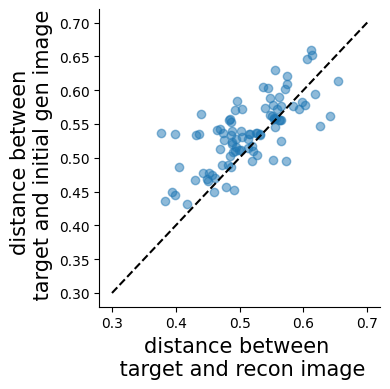

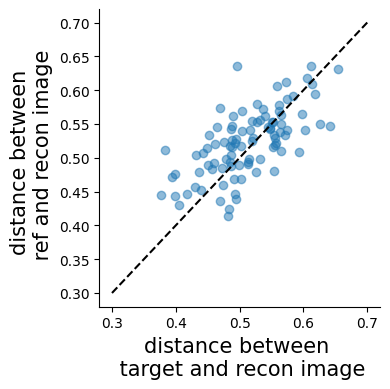

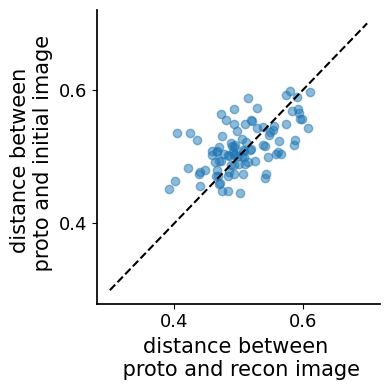

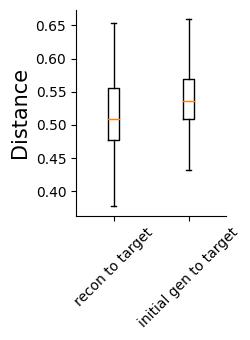

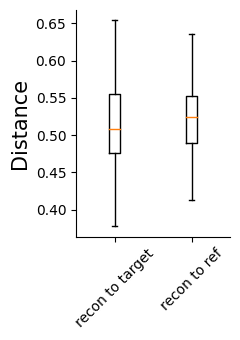

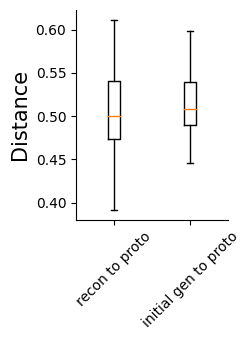

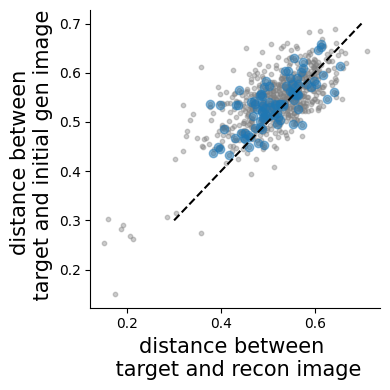

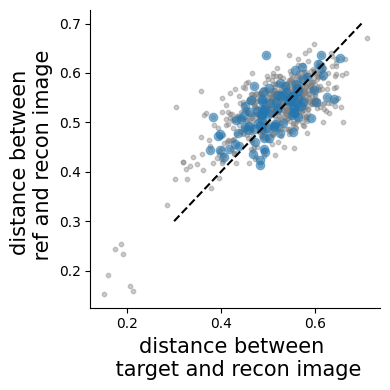

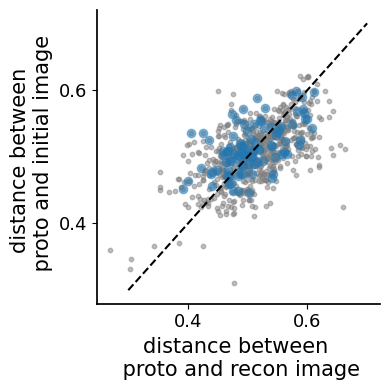

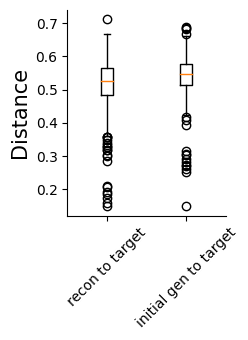

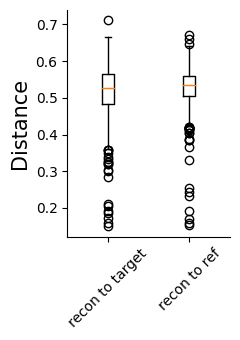

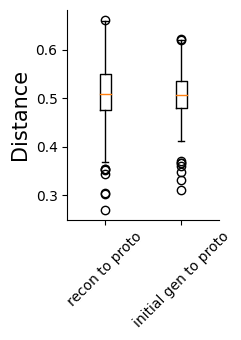

In [17]:
#let get the scater plot
save_path = os.path.join(save_root, 'all_recon_exp_sim_scater_box_plot')
os.makedirs(save_path, exist_ok=True)
if not os.path.exists(save_path):
        os.makedirs(save_path)
font_size = 15
#-------
# target to recon vs target to init gen
plt.figure(figsize=(4, 4))
plt.scatter(d_target_recon_, d_target_init_, alpha=0.5)
plt.xlabel('distance between \n target and recon image', fontsize=font_size)
plt.ylabel('distance between \n target and initial gen image', fontsize=font_size)
plt.plot([.3, .7], [.3, .7], linestyle='--', color='black')
plt.tight_layout()
plt.savefig(os.path.join(save_path, 'target_recon_vs_target_init_jus_sig.png'), dpi=300)
plt.savefig(os.path.join(save_path, 'target_recon_vs_target_init_jus_sig.pdf'), format='pdf')

# target to recon vs recon to init gen
#plt.figure(figsize=(4, 4))
#plt.scatter(d_target_recon_, d_recon_init_, alpha=0.5)
#plt.xlabel('distance between \n target and recon image', fontsize=font_size)
#plt.ylabel('distance between \n recon and initial gen image', fontsize=font_size)
#plt.plot([.1, .7], [.1, .7], linestyle='--', color='black')
#plt.tight_layout()
#plt.savefig(os.path.join(save_path, 'scatter_plot_2.png'), dpi=300)
#plt.savefig(os.path.join(save_path, 'scatter_plot_2.pdf'), format='pdf')

# target to recon vs recon to ref 
plt.figure(figsize=(4, 4))
plt.scatter(d_target_recon_, d_recn_ref_, alpha=0.5)
plt.xlabel('distance between \n target and recon image', fontsize=font_size)
plt.ylabel('distance between \n ref and recon image', fontsize=font_size)
plt.plot([.3, .7], [.3, .7], linestyle='--', color='black')
plt.tight_layout()
plt.savefig(os.path.join(save_path, 'target_recon_vs_recon_ref_jus_sig.png'), dpi=300)
plt.savefig(os.path.join(save_path, 'target_recon_vs_recon_ref_jus_sig.pdf'), format='pdf')

fig, ax = plt.subplots(1, 1, figsize=(4, 4))   
ax.scatter(d_proto_recon_, d_proto_init_, alpha=0.5)
ax.set_xlabel('distance between \n proto and recon image', fontsize=font_size)
ax.set_ylabel('distance between \n proto and initial image', fontsize=font_size)
ax.plot([.3, .7], [.3, .7], linestyle='--', color='black')
ax.spines['bottom'].set_linewidth(1.25)
ax.spines['left'].set_linewidth(1.25)
# set tixk font size
ax.tick_params(axis='both', which='major', labelsize=font_size-2)
ax.locator_params(nbins=4)
plt.tight_layout()
plt.savefig(os.path.join(save_path, 'poroto_recon_vs_poroto_init_jus_sig.png'), dpi=300)
plt.savefig(os.path.join(save_path, 'poroto_recon_vs_poroto_init_jus_sig.pdf'), format='pdf')


plt.figure(figsize=(2.5,3.5))
plt.boxplot([d_target_recon_, d_target_init_], labels=['recon to target', 'initial gen to target'])
plt.xticks(rotation=45)
plt.ylabel('Distance', fontsize=font_size)
# dose difference between the two groups is significant
_, p_val = stats.wilcoxon(d_target_recon_, d_target_init_, alternative='less')
print(f'p_val for the less between the two groups is {p_val} for the target-recon and target-init:')
plt.tight_layout()
plt.savefig(os.path.join(save_path, 'target_recon_vs_target_init_box_plot_just_sig.png'), dpi=300)
plt.savefig(os.path.join(save_path, 'target_recon_vs_target_init_box_plot_just_sig.pdf'), format='pdf')


plt.figure(figsize=(2.5,3.5))
plt.boxplot([d_target_recon_, d_recn_ref_], labels=['recon to target', 'recon to ref'])
plt.xticks(rotation=45)
plt.ylabel('Distance', fontsize=font_size)
#plt.title('Target vs Recon vs Init')
# dose difference between the two groups is significant
_, p_val = stats.wilcoxon(d_target_recon_, d_recn_ref_, alternative='less')
print(f'p_val for the less between the two groups is {p_val} for the target-recon and target-ref:')
plt.tight_layout()
plt.savefig(os.path.join(save_path, 'target_recon_vs_recon_ref_box_plot_just_sig.png'), dpi=300)
plt.savefig(os.path.join(save_path, 'target_recon_vs_recon_ref_box_plot_just_sig.pdf'), format='pdf')

plt.figure(figsize=(2.5,3.5))
plt.boxplot([d_proto_recon_, d_proto_init_], labels=['recon to proto', 'initial gen to proto'])
plt.xticks(rotation=45)
plt.ylabel('Distance', fontsize=font_size)
_, p_val = stats.wilcoxon(d_proto_recon_, d_proto_init_, alternative='less')
print(f'p_val for the less between the two groups is {p_val} for the proto-recon and proto-init:')
plt.tight_layout()
plt.savefig(os.path.join(save_path, 'proto_recon_vs_poroto_init_box_plot_just_sig.png'), dpi=300)
plt.savefig(os.path.join(save_path, 'proto_recon_vs_poroto_init_box_plot_just_sig.pdf'), format='pdf')

# let do all plot for all the data

# target to recon vs target to init gen
plt.figure(figsize=(4, 4))
plt.scatter(d_target_recon, d_target_init, alpha=0.4, color='gray', s=10)
plt.scatter(d_target_recon_, d_target_init_, alpha=0.5)
plt.xlabel('distance between \n target and recon image', fontsize=font_size)
plt.ylabel('distance between \n target and initial gen image', fontsize=font_size)
plt.plot([.3, .7], [.3, .7], linestyle='--', color='black')
plt.tight_layout()
plt.savefig(os.path.join(save_path, 'target_recon_vs_target_init_all.png'), dpi=300)
plt.savefig(os.path.join(save_path, 'target_recon_vs_target_init_all.pdf'), format='pdf')


# target to recon vs recon to ref 
plt.figure(figsize=(4, 4))
plt.scatter(d_target_recon, d_recn_ref, alpha=0.4, color='gray', s=10)
plt.scatter(d_target_recon_, d_recn_ref_, alpha=0.5)
plt.xlabel('distance between \n target and recon image', fontsize=font_size)
plt.ylabel('distance between \n ref and recon image', fontsize=font_size)
plt.plot([.3, .7], [.3, .7], linestyle='--', color='black')
plt.tight_layout()
plt.savefig(os.path.join(save_path, 'target_recon_vs_recon_ref_all.png'), dpi=300)
plt.savefig(os.path.join(save_path, 'target_recon_vs_recon_ref_all.pdf'), format='pdf')


fig, ax = plt.subplots(1, 1, figsize=(4, 4))   
ax.scatter(d_proto_recon, d_proto_init, alpha=0.5, color='gray', s=10)
ax.scatter(d_proto_recon_, d_proto_init_, alpha=0.5)
ax.set_xlabel('distance between \n proto and recon image', fontsize=font_size)
ax.set_ylabel('distance between \n proto and initial image', fontsize=font_size)
ax.plot([.3, .7], [.3, .7], linestyle='--', color='black')
ax.spines['bottom'].set_linewidth(1.25)
ax.spines['left'].set_linewidth(1.25)
# set tixk font size
ax.tick_params(axis='both', which='major', labelsize=font_size-2)
ax.locator_params(nbins=4)
plt.tight_layout()
plt.savefig(os.path.join(save_path, 'poroto_recon_vs_poroto_init_all.png'), dpi=300)
plt.savefig(os.path.join(save_path, 'poroto_recon_vs_poroto_init_all.pdf'), format='pdf')

plt.figure(figsize=(2.5,3.5))
plt.boxplot([d_target_recon, d_target_init], labels=['recon to target', 'initial gen to target'])
plt.xticks(rotation=45)
plt.ylabel('Distance', fontsize=font_size)
#plt.title('Target vs Recon vs Init')
# dose difference between the two groups is significant
_, p_val = stats.wilcoxon(d_target_recon, d_target_init, alternative='less')
print(f'p_val for the less between the two groups is {p_val} for the target-recon and target-init:')
plt.tight_layout()
plt.savefig(os.path.join(save_path, 'target_recon_vs_target_init_box_plot_all.png'), dpi=300)
plt.savefig(os.path.join(save_path, 'target_recon_vs_target_init_box_plot_all.pdf'), format='pdf')

plt.figure(figsize=(2.5,3.5))
plt.boxplot([d_target_recon, d_recn_ref], labels=['recon to target', 'recon to ref'])
plt.xticks(rotation=45)
plt.ylabel('Distance', fontsize=font_size)
#plt.title('Target vs Recon vs Init')
# dose difference between the two groups is significant
_, p_val = stats.wilcoxon(d_target_recon, d_recn_ref, alternative='less')
print(f'p_val for the less between the two groups is {p_val} for the target-recon and target-ref:')
plt.tight_layout()
plt.savefig(os.path.join(save_path, 'target_recon_vs_recon_ref_box_plot_all.png'), dpi=300)
plt.savefig(os.path.join(save_path, 'target_recon_vs_recon_ref_box_plot_all.pdf'), format='pdf')


plt.figure(figsize=(2.5,3.5))
plt.boxplot([d_proto_recon, d_proto_init], labels=['recon to proto', 'initial gen to proto'])
plt.xticks(rotation=45)
plt.ylabel('Distance', fontsize=font_size)
_, p_val = stats.wilcoxon(d_proto_recon, d_proto_init, alternative='less')
print(f'p_val for the less between the two groups is {p_val} for the proto-recon and proto-init:')
plt.tight_layout()
plt.savefig(os.path.join(save_path, 'proto_recon_vs_poroto_init_box_plot_all.png'), dpi=300)
plt.savefig(os.path.join(save_path, 'proto_recon_vs_poroto_init_box_plot_all.pdf'), format='pdf')




In [18]:
def clean_data(x, y):
    # Remove NaNs and inf
    mask = ~np.isnan(x) & ~np.isnan(y) & ~np.isinf(x) & ~np.isinf(y)
    x_clean = x[mask]
    y_clean = y[mask]
    return x_clean, y_clean
def plot_madoul(x_clean, y_clean, ax):
    ax.scatter(x_clean, y_clean)
    # Line of best fit
    m1, b1 = np.polyfit(x_clean, y_clean, 1)
    ax.plot(x_clean, m1*x_clean + b1, color='red')  # Add line of best fit
    # Calculate the correlation coefficient
    corr_coeff1 = np.corrcoef(x_clean, y_clean)[0, 1]
    ax.text(.7, 0.95, f'Corr Coeff: {corr_coeff1:.2f}', transform=ax.transAxes, fontsize=12, verticalalignment='top')

p_val for the less between the two groups is 0.0151824951171875 for the proto-recon and proto-init:


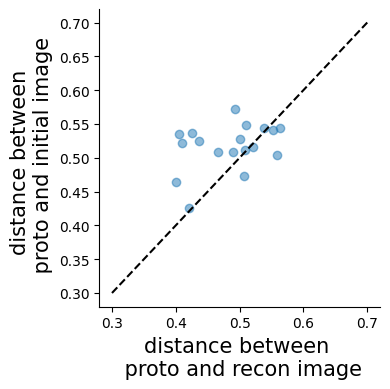

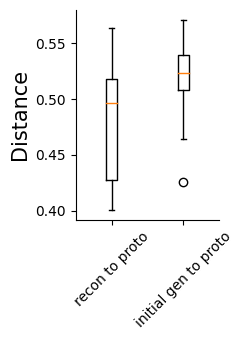

In [19]:
alpha_val = .05
delta_top_init_resp = [sub_patch_similarit_df['resp_mean_tops'].iloc[i] -  sub_patch_similarit_df['resp_mean_init'].iloc[i] for i in range(len(sub_patch_similarit_df))]
delta_top_init_resp = np.concatenate(delta_top_init_resp)

delta_top_init_p_val = [sub_patch_similarit_df['tops_greater_init'].iloc[i] for i in range(len(sub_patch_similarit_df))]
delta_top_init_p_val = np.concatenate(delta_top_init_p_val)

d_proto_init_ = [sub_patch_similarit_df['dist_proto_init_random'].iloc[i] for i in range(len(sub_patch_similarit_df))]
d_proto_recon_ = [sub_patch_similarit_df['dist_proto_tops'].iloc[i] for i in range(len(sub_patch_similarit_df))]
d_proto_init_ = np.concatenate(d_proto_init_)
d_proto_recon_ = np.concatenate(d_proto_recon_)

d_proto_init_sig_diff = d_proto_init_[delta_top_init_p_val < alpha_val]
d_proto_recon_sig_diff = d_proto_recon_[delta_top_init_p_val < alpha_val]

# let plot the scatter plot
plt.figure(figsize=(4, 4))
plt.scatter(d_proto_recon_sig_diff, d_proto_init_sig_diff, alpha=0.5) 
plt.xlabel('distance between \n proto and recon image', fontsize=font_size)
plt.ylabel('distance between \n proto and initial image', fontsize=font_size)
plt.plot([.3, .7], [.3, .7], linestyle='--', color='black')
plt.tight_layout()
plt.savefig(os.path.join(save_path, 'proto_recon_vs_poroto_init_sig_diff_during_recon.png'), dpi=300)
plt.savefig(os.path.join(save_path, 'proto_recon_vs_poroto_init_sig_diff_during_recon.pdf'), format='pdf')

# let have the box plot
plt.figure(figsize=(2.5,3.5))
plt.boxplot([d_proto_recon_sig_diff, d_proto_init_sig_diff], labels=['recon to proto', 'initial gen to proto'])
plt.xticks(rotation=45)
plt.ylabel('Distance', fontsize=font_size)
_, p_val = stats.wilcoxon(d_proto_recon_sig_diff, d_proto_init_sig_diff, alternative='less')
print(f'p_val for the less between the two groups is {p_val} for the proto-recon and proto-init:')
plt.tight_layout()
plt.savefig(os.path.join(save_path, 'proto_recon_vs_poroto_init_sig_diff_during_recon_box_plot.png'), dpi=300)
plt.savefig(os.path.join(save_path, 'proto_recon_vs_poroto_init_sig_diff_during_recon_box_plot.pdf'), format='pdf')


# let print the images
save_path = os.path.join(save_root, 'recon_proto_vs_init_proto_patches')
if not os.path.exists(save_path):
    os.makedirs(save_path)
alpha_val = .05   

for i in range(len(sub_patch_similarit_df)):
    centered_target_img = sub_patch_similarit_df['real_pos_target_img_tensor_masked_centered'].iloc[i]
    centered_best_rcon_img = sub_patch_similarit_df['real_pos_best_rcon_img_tensor_masked_centered'].iloc[i]
    centered_init_img = sub_patch_similarit_df['real_pos_best_init_img_tensor_masked_centered'].iloc[i]
    centered_proto_img = sub_patch_similarit_df['real_pos_proto_img_tensor_masked_centered'].iloc[i]
    # chech if the sub_patch_similarit_df['p_val_init_target_greater'].iloc[i]  is None 
    if sub_patch_similarit_df['tops_greater_init'].iloc[i] is None:
        continue
    filter_mask = (sub_patch_similarit_df['tops_greater_init'].iloc[i] < alpha_val)
    if np.sum(filter_mask) == 0:
        continue
    # let make grid of the images
    centered_target_img_grid = make_grid(centered_target_img[filter_mask], nrow=4, padding=1, pad_value=1)
    centered_best_rcon_img_grid = make_grid(centered_best_rcon_img[filter_mask], nrow=4, padding=1, pad_value=1)
    centered_init_img_grid = make_grid(centered_init_img[filter_mask], nrow=4, padding=1, pad_value=1)
    centered_proto_img_grid = make_grid(centered_proto_img[filter_mask], nrow=4, padding=1, pad_value=1)

    #print(sub_patch_similarit_df['resp_mean_target'].iloc[i])

    # let plot the images
    fig, ax = plt.subplots(2, 2, figsize=(10, 10))
    ax[0, 0].imshow(centered_target_img_grid.permute(1, 2, 0))
    ax[0, 0].set_title('Target Image')
    ax[0, 0].axis('off')
    ax[0, 1].imshow(centered_best_rcon_img_grid.permute(1, 2, 0))
    ax[0, 1].set_title('Best Recon Image')
    ax[0, 1].axis('off')
    ax[1, 0].imshow(centered_init_img_grid.permute(1, 2, 0))
    ax[1, 0].set_title('Initial Recon Image')
    ax[1, 0].axis('off')
    ax[1, 1].imshow(centered_proto_img_grid.permute(1, 2, 0))
    ax[1, 1].set_title('Proto Image')
    ax[1, 1].axis('off')
    plt.tight_layout()
    plt.savefig(os.path.join(save_path, f'{sub_patch_similarit_df["exp_name"].iloc[i]}_{sub_patch_similarit_df["exp_i"].iloc[i]}_{sub_patch_similarit_df["thread_id"].iloc[i]}.png'), dpi=400)
    plt.savefig(os.path.join(save_path, f'{sub_patch_similarit_df["exp_name"].iloc[i]}_{sub_patch_similarit_df["exp_i"].iloc[i]}_{sub_patch_similarit_df["thread_id"].iloc[i]}.pdf'), format='pdf')
    plt.close()
    # let plot the similarity



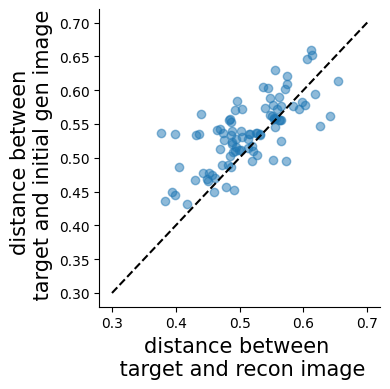

In [20]:
plt.figure(figsize=(4, 4))
plt.scatter(d_target_recon_, d_target_init_, alpha=0.5)
plt.xlabel('distance between \n target and recon image', fontsize=font_size)
plt.ylabel('distance between \n target and initial gen image', fontsize=font_size)
plt.plot([.3, .7], [.3, .7], linestyle='--', color='black')
plt.tight_layout()
plt.savefig(os.path.join(save_path, 'target_recon_vs_target_init_jus_sig.png'), dpi=300)
plt.savefig(os.path.join(save_path, 'target_recon_vs_target_init_jus_sig.pdf'), format='pdf')

c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


p_val for the less than zero of the correlation coefficient between the proto and recon images and resp is WilcoxonResult(statistic=517.0, pvalue=0.08557254388578345)


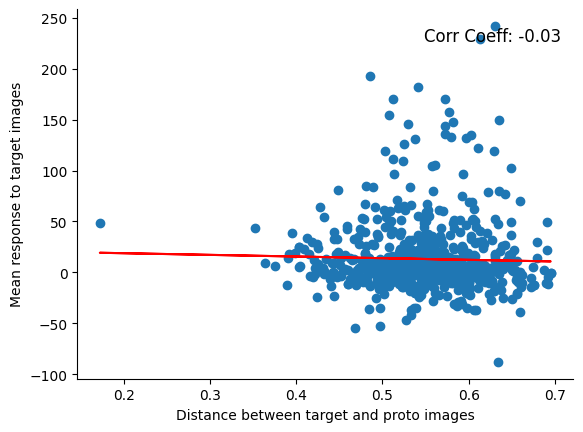

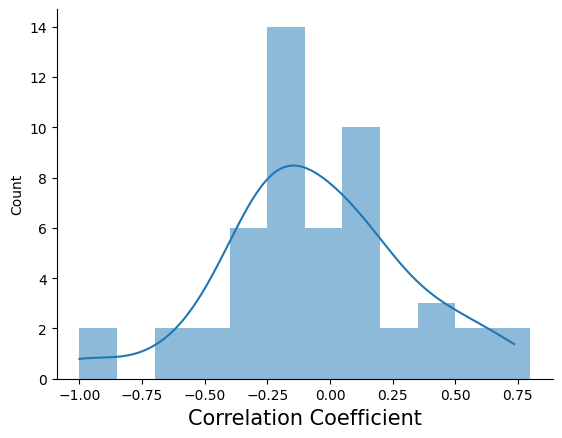

In [21]:
d_target_proto = [sub_patch_similarit_df['dist_target_proto'].iloc[i] for i in range(len(sub_patch_similarit_df))]
resp_target = [sub_patch_similarit_df['resp_mean_target'].iloc[i] for i in range(len(sub_patch_similarit_df))]

#d_target_proto= [sub_patch_similarit_df['dist_target_proto'].iloc[i][(sub_patch_similarit_df['p_val_init_target_greater'].iloc[i] < alpha_val) ] for i in range(len(sub_patch_similarit_df))]
#resp_target = [sub_patch_similarit_df['resp_mean_target'].iloc[i][(sub_patch_similarit_df['p_val_init_target_greater'].iloc[i] < alpha_val) ] for i in range(len(sub_patch_similarit_df))]

d_target_proto = np.concatenate(d_target_proto)
resp_target = np.concatenate(resp_target)
fig, ax = plt.subplots()
x_clean, y_clean = clean_data(d_target_proto, resp_target)
plot_madoul(x_clean, y_clean, ax)
ax.set_xlabel('Distance between target and proto images')
ax.set_ylabel('Mean response to target images')
# let get distribution of the the correlation coefficient for the dist_proto_recon and resp_mean_target for each experiment
corr_coeff = np.array([np.corrcoef(sub_patch_similarit_df['dist_target_proto'].iloc[i], sub_patch_similarit_df['resp_mean_target'].iloc[i])[0, 1] for i in range(len(sub_patch_similarit_df))])
corr_coeff = corr_coeff[~np.isnan(corr_coeff)]
plt.figure()
sns.histplot(corr_coeff, kde=True, label='masked', alpha=0.5, binwidth=0.15, linewidth=0)
plt.xlabel('Correlation Coefficient', fontsize=font_size)

p_val = stats.wilcoxon(corr_coeff, alternative='less')
print(f'p_val for the less than zero of the correlation coefficient between the proto and recon images and resp is {p_val}')

In [22]:
sub_patch_similarit_df['proto_resp_mean'].iloc[i] 


array([ 20.50107327,  57.01805821, 132.98873007, 254.25982361,
        43.72042128,  40.70019278,  80.24796572,  23.6121579 ,
        80.97883942])

C:\Users\Alireza\AppData\Local\Temp\ipykernel_24220\2516620370.py:19: RuntimeWarning: divide by zero encountered in divide
  corr_coeff = np.array([np.corrcoef(sub_patch_similarit_df['dist_proto_recon'].iloc[i], (sub_patch_similarit_df['resp_mean_tops'].iloc[i]/sub_patch_similarit_df['resp_mean_init'].iloc[i]).squeeze())[0, 1] for i in range(len(sub_patch_similarit_df))])
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\numpy\lib\function_base.py:2698: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\numpy\lib\functio

p_val for the less than zero of the correlation coefficient between the proto and recon images and resp is 0.9152891277335584


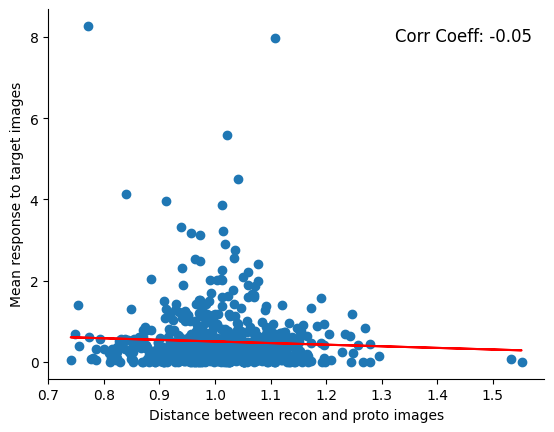

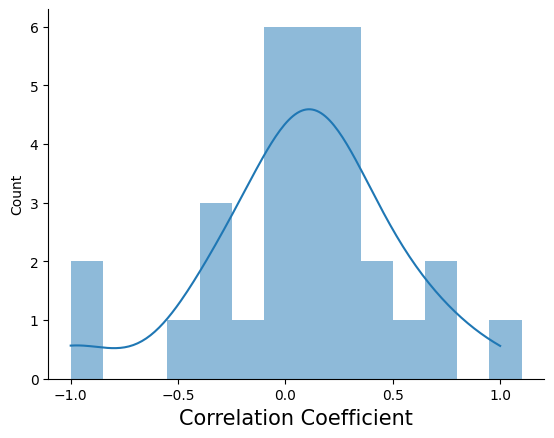

In [23]:
d_recon_proto = [sub_patch_similarit_df['dist_proto_tops'].iloc[i]/sub_patch_similarit_df['dist_proto_init_random'].iloc[i] for i in range(len(sub_patch_similarit_df))]
#resp_recon = [sub_patch_similarit_df['resp_mean_tops'].iloc[i] for i in range(len(sub_patch_similarit_df))]
resp_recon = [sub_patch_similarit_df['resp_mean_tops'].iloc[i]/sub_patch_similarit_df['proto_resp_mean'].iloc[i] for i in range(len(sub_patch_similarit_df))]

#d_recon_proto = [sub_patch_similarit_df['dist_proto_tops'].iloc[i][(sub_patch_similarit_df['p_val_init_target_greater'].iloc[i] < alpha_val) ] for i in range(len(sub_patch_similarit_df))]
#resp_recon = [sub_patch_similarit_df['resp_mean_best_gen'].iloc[i][(sub_patch_similarit_df['p_val_init_target_greater'].iloc[i] < alpha_val) ] for i in range(len(sub_patch_similarit_df))]
d_recon_proto = np.concatenate(d_recon_proto)
resp_recon = np.concatenate(resp_recon)
resp_recon = resp_recon.squeeze()


fig, ax = plt.subplots()
x_clean, y_clean = clean_data(d_recon_proto, resp_recon)
plot_madoul(x_clean, y_clean, ax)
# add axis label
plt.xlabel('Distance between recon and proto images')
plt.ylabel('Mean response to target images')
# let get distribution of the the correlation coefficient for the dist_proto_recon and resp_mean_target for each experiment
corr_coeff = np.array([np.corrcoef(sub_patch_similarit_df['dist_proto_recon'].iloc[i], (sub_patch_similarit_df['resp_mean_tops'].iloc[i]/sub_patch_similarit_df['resp_mean_init'].iloc[i]).squeeze())[0, 1] for i in range(len(sub_patch_similarit_df))])
corr_coeff = corr_coeff[~np.isnan(corr_coeff)]
plt.figure()
sns.histplot(corr_coeff, kde=True, label='masked', alpha=0.5, binwidth=0.15, linewidth=0)
plt.xlabel('Correlation Coefficient', fontsize=font_size)
# whether this distribution is sinifcantly less than 0
# Lk
p_val = stats.wilcoxon(corr_coeff, alternative='less')[1]
print(f'p_val for the less than zero of the correlation coefficient between the proto and recon images and resp is {p_val}')

Text(0, 0.5, 'Response')

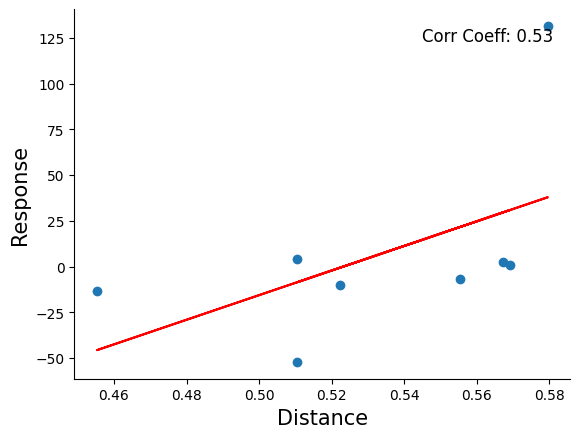

In [24]:
i =0 
d_recon_proto = sub_patch_similarit_df['dist_proto_tops'].iloc[i]
resp_recon = sub_patch_similarit_df['resp_mean_target'].iloc[i]

fig, ax = plt.subplots()
x_clean, y_clean = clean_data(d_recon_proto, resp_recon)
plot_madoul(x_clean, y_clean, ax)
# add axis label
plt.xlabel('Distance', fontsize=font_size)
plt.ylabel('Response', fontsize=font_size)

In [25]:
"""
avg_strip = 2
file_name_patern = r'^(.*?)_expId(\d{3}).mat$'
exp_i = 9
iThread = 0
file_name = recon_exp_files[exp_i] 
matches = re.match(file_name_patern, file_name)
exp_name, expriment_id = matches.groups()
expriment_id = int(expriment_id)
exp_date = exp_name.split('-')[1]
exp_datetime_obj = parse_date(exp_date, animal_name = animal_name)

recon_data = load_mat_data(os.path.join(recon_exp_path, recon_exp_files[exp_i]))
nun_of_thread = int(recon_data['num_of_thread'])

is_gen, block_ids, thread_ids, gen_ids, counters, is_nat, nat_gen = process_gen_image_strings(recon_data['all_img_name_recon'])
thread_mask = (thread_ids == iThread)
sub_resp = recon_data['evoke_resp_recon'] - recon_data['bk_resp_reocn']

target_resp = recon_data['target_resps_cell'][iThread]
total_mean = recon_data['pop_mean_call'][iThread]
total_std = recon_data['pop_std_cell'][iThread]
target_resp = (target_resp- total_mean) / total_std
sub_resp_norm = (sub_resp - total_mean[:, None]) / total_std[:, None]
resp_mean, resp_std, resp_sem, resp_uique_gen = analyze_by_gen(sub_resp_norm[:, thread_mask], gen_ids[thread_mask])

resp_mean = resp_mean[recon_data['masks_cell'][iThread]]
resp_std = resp_std[recon_data['masks_cell'][iThread]]
resp_sem = resp_sem[recon_data['masks_cell'][iThread]]
target_resp = target_resp[recon_data['masks_cell'][iThread]]


this_thread_imgs = recon_data['all_img_name_recon'][thread_mask]
score_vec = get_score_from_resp(sub_resp, recon_data['target_resps_cell'][iThread], recon_data['masks_cell'][iThread], recon_data['score_mods'][iThread], recon_data['pop_mean_call'][iThread], recon_data['pop_std_cell'][iThread])
score_means, score_stds, score_sems, score_gens = analyze_by_gen(score_vec[thread_mask], gen_ids[thread_mask])
score_from_bhv =np.array([np.nanmean(x) for x in recon_data['score_cell_bhv2']])
# let replace score of each gen (except the first one) with the mean of the previous gens
score_means_smooth = score_means.copy()
for i in range(1, len(score_means)):
        score_means_smooth[i] = np.nanmean(score_means[i-avg_strip+1:i+1])
best_gen = int(score_gens[np.argmax(score_means_smooth)])
inital_gen_score = score_vec[thread_mask & (gen_ids == 0)]
best_gen_score = score_vec[thread_mask & (gen_ids == best_gen)] # score_vec[thread_mask & ((gen_ids == best_gen) | (gen_ids == best_gen-1))] #TODO ASK THIS

best_gen_resp_mean = resp_mean[:, resp_uique_gen == best_gen]
best_gen_resp_sem = resp_sem[:, resp_uique_gen == best_gen]

ini_resp_mean = resp_mean[:, resp_uique_gen == 0]
ini_resp_sem = resp_sem[:, resp_uique_gen == 0]


# let's find the noise ceiling
evoke_resp_select = recon_data['evoke_resp_select']
bk_resp_select = recon_data['bk_resp_select']
sub_resp_select = evoke_resp_select - bk_resp_select
target_img_name = recon_data['target_name'][iThread]
target_img_idx = [(target_img_name == img_name) for img_name in recon_data['all_img_name_select']]
target_resp_from_mat = sub_resp_select[:, target_img_idx]
unit_ids_select = recon_data['unit_ids_select']
unit_ids_recon = recon_data['unit_ids_recon']
select_mask = get_selectivity_exp_coresponded_mask(recon_data, iThread)
all_trails_noise, half_draw_noise, one_out_noise = get_target_noise_celling(
        target_resp_from_mat, select_mask, recon_data['score_mods'][iThread], recon_data['pop_mean_call'][iThread], recon_data['pop_std_cell'][iThread], diff_mask= True, second_mask = recon_data['masks_cell'][iThread]) 
# let's tun the rank sum test (wilcoxon) one sided to see if the best gen is better than the initial gen
_, p_val = stats.ranksums(inital_gen_score, best_gen_score, alternative='less') 

# let here have get score with MSE no matter what the score mode is
# let's get the MSE score
score_vec_MSE = get_score_from_resp(sub_resp, recon_data['target_resps_cell'][iThread], recon_data['masks_cell'][iThread], 'MSE', recon_data['pop_mean_call'][iThread], recon_data['pop_std_cell'][iThread])
score_means_MSE, score_stds_MSE, score_sems_MSE, score_gens_MSE = analyze_by_gen(score_vec_MSE[thread_mask], gen_ids[thread_mask])
score_means_smooth_MSE = score_means_MSE.copy()
for i in range(1, len(score_means_MSE)):
        score_means_smooth_MSE[i] = np.nanmean(score_means_MSE[i-avg_strip+1:i+1])
best_gen_MSE = int(score_gens_MSE[np.argmax(score_means_smooth_MSE)])
inital_gen_score_MSE = score_vec_MSE[thread_mask & (gen_ids == 0)]
best_gen_score_MSE = score_vec_MSE[thread_mask & ((gen_ids == best_gen_MSE))] # score_vec_MSE[thread_mask & ((gen_ids == best_gen_MSE) | (gen_ids == best_gen_MSE-1))] #TODO ASK THIS
# let's tun the rank sum test (wilcoxon) one sided to see if the best gen is better than the initial gen
_, p_val_MSE = stats.ranksums(inital_gen_score_MSE, best_gen_score_MSE, alternative='less')

all_trails_noise_MSE, half_draw_noise_MSE, one_out_noise_MSE = get_target_noise_celling(
        target_resp_from_mat, select_mask, 'MSE', recon_data['pop_mean_call'][iThread], recon_data['pop_std_cell'][iThread], diff_mask= True, second_mask = recon_data['masks_cell'][iThread])

# let which neurons have different responses to target to initial gen and best gen
target_resp_mask = target_resp_from_mat[select_mask, :]
best_gen_resp_mask = sub_resp[recon_data['masks_cell'][iThread], :][:, ((gen_ids == best_gen) & (thread_ids == iThread))]
ini_resp_mask = sub_resp[recon_data['masks_cell'][iThread], :][:, ((gen_ids == 0) & (thread_ids == iThread))]

p_val_init_target = list()
p_val_best_target = list()
for i in range(target_resp_mask.shape[0]):
        _, p_val_i_t = stats.ranksums(ini_resp_mask[i, :], target_resp_mask[i, :])
        _, p_val_i_b = stats.ranksums(best_gen_resp_mask[i, :], target_resp_mask[i, :])
        p_val_init_target.append(p_val_i_t)
        p_val_best_target.append(p_val_i_b)
p_val_init_target = np.array(p_val_init_target)
p_val_best_target = np.array(p_val_best_target)
chan_ids = recon_data['chan_ids_recon'][recon_data['masks_cell'][iThread]]
unit_ids = recon_data['unit_ids_recon'][recon_data['masks_cell'][iThread]]

plt.figure()
plt.plot(np.nanmean(target_resp_mask, axis=1), label='sub_resp_norm', color='black')
plt.plot(np.nanmean(ini_resp_mask, axis=1), label='ini_resp_mean', color='blue')
plt.plot(np.nanmean(best_gen_resp_mask, axis=1), label='best_gen_resp_mean', color='red')
plt.plot(np.where(p_val_init_target<.01)[0], np.ones(np.sum(p_val_init_target<.01))*100, 'o', color='green')
plt.plot(np.where(p_val_best_target<.01)[0], np.ones(np.sum(p_val_best_target<.01))*-50, 'o', color='orange')       
"""

"\navg_strip = 2\nfile_name_patern = r'^(.*?)_expId(\\d{3}).mat$'\nexp_i = 9\niThread = 0\nfile_name = recon_exp_files[exp_i] \nmatches = re.match(file_name_patern, file_name)\nexp_name, expriment_id = matches.groups()\nexpriment_id = int(expriment_id)\nexp_date = exp_name.split('-')[1]\nexp_datetime_obj = parse_date(exp_date, animal_name = animal_name)\n\nrecon_data = load_mat_data(os.path.join(recon_exp_path, recon_exp_files[exp_i]))\nnun_of_thread = int(recon_data['num_of_thread'])\n\nis_gen, block_ids, thread_ids, gen_ids, counters, is_nat, nat_gen = process_gen_image_strings(recon_data['all_img_name_recon'])\nthread_mask = (thread_ids == iThread)\nsub_resp = recon_data['evoke_resp_recon'] - recon_data['bk_resp_reocn']\n\ntarget_resp = recon_data['target_resps_cell'][iThread]\ntotal_mean = recon_data['pop_mean_call'][iThread]\ntotal_std = recon_data['pop_std_cell'][iThread]\ntarget_resp = (target_resp- total_mean) / total_std\nsub_resp_norm = (sub_resp - total_mean[:, None]) / tota